# Model

In this class, we will develop a baseline for Task 2 using a subset of the lego dataset. We will model the task as an ordinal classification task.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2
from torch import nn
from torch.utils.data import DataLoader, Dataset, Sampler, WeightedRandomSampler
import torch.nn.functional as F
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, balanced_accuracy_score
from tqdm import tqdm
from collections import defaultdict
import seaborn as sns

## Load dataset

In the Lego dataset, the images are organized into folders according to the number of legos. In this notebook, we will only consider images with up to 32 legos.

In [3]:
# images_directory = "drive/MyDrive/VC/photos_modified"
train_test_split = "drive/MyDrive/VC/train_test_split.csv"

# !cp -r $images_directory /content/
!cp -r $train_test_split /content/

!unzip "drive/MyDrive/VC/photos.zip"

Archive:  drive/MyDrive/VC/photos.zip
   creating: photos/
   creating: photos/15/
  inflating: photos/15/IMG_20201127_003103.jpg  
  inflating: photos/15/IMG_20201127_003312.jpg  
  inflating: photos/15/IMG_20201127_001617.jpg  
  inflating: photos/15/IMG_20201127_003321.jpg  
  inflating: photos/15/IMG_20201127_003306.jpg  
   creating: photos/18/
  inflating: photos/18/IMG_20201127_002132.jpg  
  inflating: photos/18/IMG_20201127_002125.jpg  
  inflating: photos/18/IMG_20201127_003507.jpg  
  inflating: photos/18/IMG_20201127_193750.jpg  
  inflating: photos/18/IMG_20201127_002055.jpg  
  inflating: photos/18/IMG_20201127_193635.jpg  
  inflating: photos/18/IMG_20201127_003500.jpg  
   creating: photos/1/
  inflating: photos/1/IMG_20201208_015222.jpg  
  inflating: photos/1/IMG_20201211_164755.jpg  
  inflating: photos/1/0_VkyO_original_1609001209825.jpg  
  inflating: photos/1/0_yZgq_original_3460_1609896016846.jpg  
  inflating: photos/1/2_0ZLw_original-test_1609970942744.jpg  
  

In [ ]:
# function to create a new image by stitching other n images together
def generate_LEGOs(images_list, number_legos, number_samples):
    random.seed(42)
    new_images = []

    for _ in range(number_samples):
        image_samples = random.sample(images_list, number_legos)

        # Load the images
        images = [cv2.imread(image_samples.pop()) for _ in range(number_legos)]

        # Resize the images
        images = [cv2.resize(img, (512, 512)) for img in images]

        # Calculate the size of the grid
        side = int(np.ceil(np.sqrt(n)))

        # Create a new image with appropriate size
        new_image = np.zeros((512 * side, 512 * side, 3), dtype=np.uint8)

        # Append empty images if necessary
        while len(images) < side * side:
            # Append empty images with random color and noise
            empty_image = np.random.randint(0, 256, (512, 512, 3), dtype=np.uint8)
            # empty_image = cv2.GaussianBlur(empty_image, (51, 51), 0)
            images.append(empty_image)

        # Shuffle the images
        random.shuffle(images)

        # Stitch images in a grid without blending
        for i in range(side):
            for j in range(side):
                idx = i * side + j
                new_image[i * 512:(i + 1) * 512, j * 512:(j + 1) * 512, :] = images[idx]


        # Create a list with random widths with length side * 512
        # widths_h = np.random.randint(30, 200, (side + 1) * 512)
        # widths_v = np.random.randint(30, 200, (side + 1) * 512)

        # for i in range(side):
        #     for j in range(side + 1):
        #         for p in range(512):
        #             width_h = widths_h[i * 512 + p]
        #             width_v = widths_v[j * 512 + p]

        #             # Blend horizontally
        #             pixels_h = new_image[i * 512 - width_h//2:i * 512 + width_h//2, j*p, :] + new_image[i * 512 - width_h//2:i * 512 + width_h//2, j*p, :]
        #             np.random.shuffle(pixels_h)
        #             # Blend vertically
        #             pixels_v = new_image[j*p, i * 512 - width_v//2:i * 512 + width_v//2, :] + new_image[j*p, i * 512 - width_v//2:i * 512 + width_v//2, :]
        #             np.random.shuffle(pixels_v)

        #             new_image[i * 512 - width_v//2:i * 512 + width_v//2, j * p, :] = pixels_v
        #             new_image[j * p, i * 512 - width_h//2:i * 512 + width_h//2, :] = pixels_h


        # Resize the new image to 244x244
        new_image = cv2.resize(new_image, (244, 244))

        new_images.append(new_image)

    return new_images

Size of Images List: 8899
Size of Number Legos List: 8899


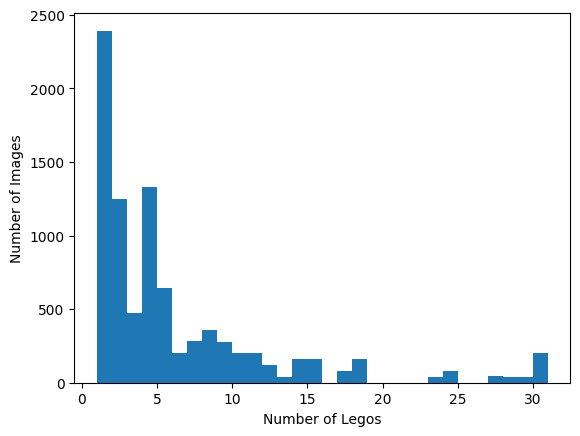

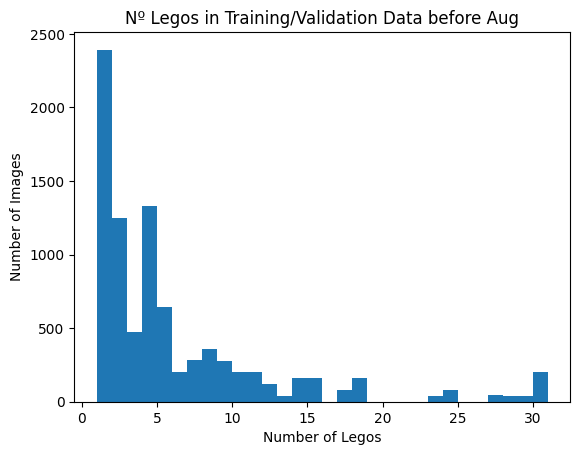

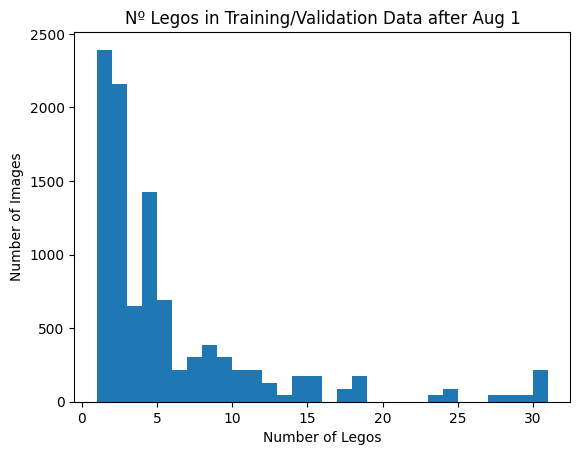

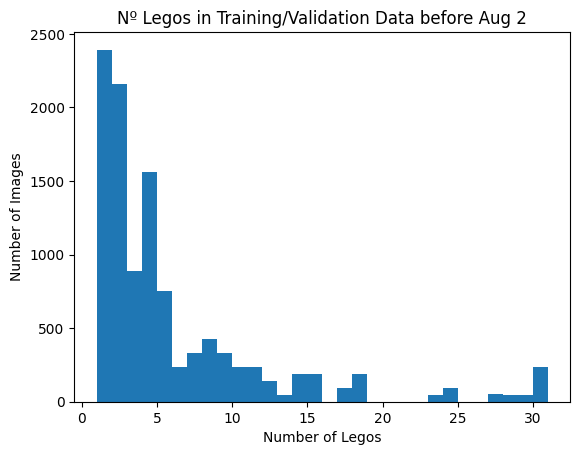

Size of Train Data: 3853
Size of Validation Data: 964
Size of Test Data: 274


In [29]:
random.seed(42)

# Obtain names of images for training and validation
image_paths = []
num_legos = []

for dirpath, dirnames, filenames in os.walk("photos"):
    for filename in filenames:
        # Check how many legos the image has
        n = int(dirpath.split(os.sep)[-1])
        if filename.endswith('.jpg'):
          image_paths.append(os.path.join(dirpath, filename))
          num_legos.append(n)

print(f"Size of Images List: {len(image_paths)}")
print(f"Size of Number Legos List: {len(num_legos)}")

# plot histogram of number of images per lego
plt.hist(num_legos, bins=range(1, 32), align='mid')
plt.xlabel("Number of Legos")
plt.ylabel("Number of Images")
plt.show()

# Using train test split gived by teacher in train_test_split.cv

train_val_indexes = []
train_indexes = []
validation_indexes = []
test_indexes = []

# read .cv file and skip first line
with open("train_test_split.csv", "r") as f:
    lines = f.readlines()[1:]
    for line in lines:
        line = line.split(",")
        if line[1] == "1\n":
            test_indexes.append(image_paths.index(line[0]))
        else:
            train_val_indexes.append(image_paths.index(line[0]))

# plot histogram of number of images per lego
plt.hist(num_legos, bins=range(1, 32), align='mid')
plt.title("Nº Legos in Training/Validation Data before Aug")
plt.xlabel("Number of Legos")
plt.ylabel("Number of Images")
plt.show()

# Data Aug for train dataset
new_image_paths = []

for dirpath, dirnames, filenames in os.walk("photos"):
    for filename in filenames:
        if image_paths.index(os.path.join(dirpath, filename)) in train_val_indexes:
            # Check how many legos the image has
            n = int(dirpath.split(os.sep)[-1])
            if filename.endswith('.jpg'):
                # Read the image
                image = cv2.imread(os.path.join(dirpath, filename))
                if image is None:
                    print(f"Failed to read image: {os.path.join(dirpath, filename)}")
                    continue
                if n != 1:
                    # Rotate the images and save them
                    for r, rotation_flag in enumerate([cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE], start=1):
                        rotated_image = cv2.rotate(image, rotation_flag)
                        new_image_path = os.path.join(dirpath, filename.replace(".jpg", f"_rotated{r*90}.jpg"))
                        success = cv2.imwrite(new_image_path, rotated_image)
                        if not success:
                            print(f"Failed to write image: {new_image_path}")
                            continue
                        image_paths.append(new_image_path)
                        num_legos.append(n)
                        new_image_paths.append(new_image_path)

for path in new_image_paths:
    train_val_indexes.append(image_paths.index(path))
new_image_paths = []

# plot histogram of number of images per lego
plt.hist(num_legos, bins=range(1, 32), align='mid')
plt.title("Nº Legos in Training/Validation Data after Aug 1")
plt.xlabel("Number of Legos")
plt.ylabel("Number of Images")
plt.show()

for dirpath, dirnames, filenames in os.walk("photos"):
    for filename in filenames:
        if image_paths.index(os.path.join(dirpath, filename)) in train_val_indexes:
            # Check how many legos the image has
            n = int(dirpath.split(os.sep)[-1])
            if filename.endswith('.jpg'):
                # Read the image
                image = cv2.imread(os.path.join(dirpath, filename))
                if image is None:
                    print(f"Failed to read image: {os.path.join(dirpath, filename)}")
                    continue
                if n not in [1,2]:
                    flipped_image = cv2.flip(image, 1)
                    new_image_path = os.path.join(dirpath, filename.replace(".jpg", f"_flipped.jpg"))
                    success = cv2.imwrite(new_image_path, flipped_image)
                    if not success:
                        print(f"Failed to write image: {new_image_path}")
                        continue
                    image_paths.append(new_image_path)
                    num_legos.append(n)
                    new_image_paths.append(new_image_path)

for path in new_image_paths:
    train_val_indexes.append(image_paths.index(path))
new_image_paths = []

# plot histogram of number of images per lego
plt.hist(num_legos, bins=range(1, 32), align='mid')
plt.title("Nº Legos in Training/Validation Data before Aug 2")
plt.xlabel("Number of Legos")
plt.ylabel("Number of Images")
plt.show()


# Shuffle the train indexes to randomize the split
random.shuffle(train_val_indexes)

# Calculate the split point
split_point = int(0.8 * len(train_val_indexes))

# Split the train indexes into train and validation
train_indexes, validation_indexes = train_val_indexes[:split_point], train_val_indexes[split_point:]

image_paths = np.asarray(image_paths)
num_legos = torch.Tensor(num_legos).to(torch.int64)

print(f"Size of Train Data: {len(train_indexes)}")
print(f"Size of Validation Data: {len(validation_indexes)}")
print(f"Size of Test Data: {len(test_indexes)}")


In [6]:
class LegosDataset(Dataset):
    def __init__(self, images_filenames, num_legos, transform=None):
        self.images_filenames = images_filenames
        self.transform = transform

        # Transform number of legos into one hot encoding
        self.labels = num_legos - 1

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        label = self.labels[idx]

        # print("filename: ", image_filename)

        # Read image
        image = cv2.imread(image_filename)

        # Convert from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply the same data augmentation to both input image and target mask
        if self.transform is not None:
            image = self.transform(image)

        return image, label

class ClassBalancedBatchSampler(Sampler):
    def __init__(self, data_source, num_classes):
        self.data_source = data_source
        self.num_classes = num_classes
        self.class_indices = defaultdict(list)

        # Collect indices for each class
        for idx, label in enumerate(data_source.labels):
            self.class_indices[label.item()].append(idx)

        # print(self.class_indices)

        # Ensure each class has at least one sample
        self.available_classes = [class_idx for class_idx in range(num_classes) if class_idx in self.class_indices]
        self.used_idx = set()

        # print(self.available_classes)

        # self.max_class_size = max(len(self.class_indices[class_idx]) for class_idx in self.available_classes)

        # Calculate the number of batches per epoch
        self.num_batches = len(self.data_source) // self.num_classes

    def __iter__(self):
        batch = []
        for _ in range(self.num_batches):
            for class_idx in self.available_classes:
                idx = random.choice(self.class_indices[class_idx])
                # just to know if using all images
                self.used_idx.add(idx)

                batch.append(idx)
                if len(batch) == self.num_classes:
                    yield batch
                    random.shuffle(batch)
                    batch = []
                    break

            # If batch is not filled (due to missing classes), fill it with random available indices
            while len(batch) < self.num_classes:
                # idx = random.choice(self.class_indices[0])
                idx = random.choice(self.class_indices[random.choice(self.available_classes)])
                batch.append(idx)
                if len(batch) == self.num_classes:
                    random.shuffle(batch)
                    yield batch
                    batch = []
                    break
        # print("Size of unique images used: ", len(self.used_idx))

    def __len__(self):
        return self.num_batches

class WeightedBalancedBatchSampler(Sampler):
    def __init__(self, dataset, num_classes):
        self.dataset = dataset
        self.num_classes = num_classes

        # Collect indices for each class
        self.class_indices = defaultdict(list)
        for idx, label in enumerate(dataset.labels):
            self.class_indices[label].append(idx)

        # Calculate class weights
        class_counts = [len(indices) for indices in self.class_indices.values()]
        total_samples = sum(class_counts)
        class_weights = [total_samples / (self.num_classes * count) for count in class_counts]

        # Create a weighted random sampler
        self.weighted_sampler = WeightedRandomSampler(class_weights, total_samples)

    def __iter__(self):
        # Initialize a list to store batch indices
        batch_indices = []
        for idx in self.weighted_sampler:
            batch_indices.append(idx)
            if len(batch_indices) == self.num_classes:
                yield batch_indices
                batch_indices = []

    def __len__(self):
        return len(self.weighted_sampler) // self.num_classes

In [27]:
batch_size = 32
num_workers = 2
num_classes = 32

# Define transformations to be applied to data
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)


# Define datasets
train_dataset = LegosDataset(image_paths[train_indexes], num_legos[train_indexes], transform=transform)
validation_dataset = LegosDataset(image_paths[validation_indexes], num_legos[validation_indexes], transform=transform)
test_dataset = LegosDataset(image_paths[test_indexes], num_legos[test_indexes], transform=transform)

# Use custom batch sampler for the training dataloader
train_batch_sampler = ClassBalancedBatchSampler(train_dataset, num_classes)
# train_batch_sampler = WeightedBalancedBatchSampler(train_dataset, num_classes)

# Calculate class weights based on the frequency of each class
def calculate_class_weights(labels):
    class_counts = torch.bincount(labels)
    total_samples = len(labels)
    class_weights = total_samples / class_counts
    return class_weights

# Calculate sample weights based on the class weights
def calculate_sample_weights(labels, class_weights):
    sample_weights = class_weights[labels]
    return sample_weights

# Calculate class weights and sample weights for the training dataset
train_labels = torch.tensor(train_dataset.labels)
class_weights = calculate_class_weights(train_labels)
sample_weights = calculate_sample_weights(train_labels, class_weights)

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Define dataloaders
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
# train_dataloader = DataLoader(train_dataset, batch_sampler=train_batch_sampler, num_workers=num_workers)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=num_workers, shuffle=False)

<ipython-input-27-3a5d99487381>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_dataset.labels)


## Defining the model

Load a pre-trained convolutional neural network of your own choice from torchvision.

In [ ]:
# # Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using {device} device")

# # Load a pre-trained convolutional neural network of your own choice from torchvision. Do not forget to change the last layer to match the number of classes = 32.
# model = models.resnet18(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, 32)

# # Freeze all layers except the last one
# for name, param in model.named_parameters():
#     if "fc" not in name:
#         param.requires_grad = False

# model.to(device)

## Train the model

Define function to perform one iteration

In [8]:
def epoch_iter(model, dataloader, loss_fn, optimizer=None, train=True):
    if train:
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    all_labels = []
    all_predictions = []

    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # print("")
        # print("Batch Labels: ", labels)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            if train:
                loss.backward()
                optimizer.step()

        running_loss += loss.item()

        final_label = labels.cpu().numpy()
        final_prediction = outputs.argmax(dim=1).detach().cpu().numpy()

        all_labels.extend(final_label)
        all_predictions.extend(final_prediction)

    loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    balanced_accuracy = balanced_accuracy_score(all_labels, all_predictions)

    print("Labels:      [", ', '.join([f"{item:2}" for item in all_labels]), "]")
    print("Predictions: [", ', '.join([f"{item:2}" for item in all_predictions]), "]")

    return loss, accuracy, precision, recall, balanced_accuracy

Define function to train a model

In [9]:
def train(model_name, model, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
    train_history = {'loss': [], 'accuracy': [], 'balanced_accuracy': [], 'precision': [], 'recall': []}
    val_history = {'loss': [], 'accuracy': [], 'balanced_accuracy': [], 'precision': [], 'recall': []}

    best_val_loss = np.inf

    print("Start training")

    for t in range(num_epochs):
        print(f"\nEpoch {t+1}")
        train_loss, train_acc, train_precision, train_recall, train_balanced_acc = epoch_iter(model, train_dataloader, loss_fn, optimizer)
        print(f"Train loss: {train_loss:.3f} | Train accuracy: {train_acc:.3f} | Train balanced accuracy: {train_balanced_acc:.3f} | Train precision: {train_precision:.3f} | Train recall: {train_recall:.3f}")
        val_loss, val_acc, val_precision, val_recall, val_balanced_acc = epoch_iter(model, validation_dataloader, loss_fn, train=False)
        print(f"Val loss: {val_loss:.3f} | Val accuracy: {val_acc:.3f} | Val balanced accuracy: {val_balanced_acc:.3f} | Val precision: {val_precision:.3f} | Val recall: {val_recall:.3f}")

        # save model when val loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
            torch.save(save_dict, 'drive/MyDrive/VC/' + model_name + '_best_model.pth')

        # save latest model
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, 'drive/MyDrive/VC/' + model_name + '_latest_model.pth')

        # save training history for plotting purposes
        train_history["loss"].append(train_loss)
        train_history["accuracy"].append(train_acc)
        train_history["balanced_accuracy"].append(train_balanced_acc)
        train_history["precision"].append(train_precision)
        train_history["recall"].append(train_recall)

        val_history["loss"].append(val_loss)
        val_history["accuracy"].append(val_acc)
        val_history["balanced_accuracy"].append(val_balanced_acc)
        val_history["precision"].append(val_precision)
        val_history["recall"].append(val_recall)

    print("Finished training")
    return train_history, val_history


## Analyse training evolution

In [10]:
def plotTrainingHistory(train_history1, val_history1, train_history2, val_history2, model_name):
    plt.figure(figsize=(12, 10))

    x1 = range(len(train_history1['loss']))
    x2 = range(len(train_history1['loss']), len(train_history1['loss']) + len(train_history2['loss']))

    # Plot loss
    plt.subplot(3, 2, 1)
    plt.title('Loss')
    plt.plot(x1, train_history1['loss'], label='train1', color='blue')
    plt.plot(x1, val_history1['loss'], label='val1', color='red')
    plt.plot(x2, train_history2['loss'], label='train2', color='blue')
    plt.plot(x2, val_history2['loss'], label='val2', color='red')
    plt.legend(loc='best')

    # Plot accuracy
    plt.subplot(3, 2, 2)
    plt.title('Accuracy')
    plt.plot(x1, train_history1['accuracy'], label='train1', color='blue')
    plt.plot(x1, val_history1['accuracy'], label='val1', color='red')
    plt.plot(x2, train_history2['accuracy'], label='train2', color='blue')
    plt.plot(x2, val_history2['accuracy'], label='val2', color='red')
    plt.legend(loc='best')

    # Plot balanced accuracy
    plt.subplot(3, 2, 3)
    plt.title('Balanced Accuracy')
    plt.plot(x1, train_history1['balanced_accuracy'], label='train1', color='blue')
    plt.plot(x1, val_history1['balanced_accuracy'], label='val1', color='red')
    plt.plot(x2, train_history2['balanced_accuracy'], label='train2', color='blue')
    plt.plot(x2, val_history2['balanced_accuracy'], label='val2', color='red')
    plt.legend(loc='best')

    # Plot precision
    plt.subplot(3, 2, 4)
    plt.title('Precision')
    plt.plot(x1, train_history1['precision'], label='train1', color='blue')
    plt.plot(x1, val_history1['precision'], label='val1', color='red')
    plt.plot(x2, train_history2['precision'], label='train2', color='blue')
    plt.plot(x2, val_history2['precision'], label='val2', color='red')
    plt.legend(loc='best')

    # Plot recall
    plt.subplot(3, 2, 5)
    plt.title('Recall')
    plt.plot(x1, train_history1['recall'], label='train1', color='blue')
    plt.plot(x1, val_history1['recall'], label='val1', color='red')
    plt.plot(x2, train_history2['recall'], label='train2', color='blue')
    plt.plot(x2, val_history2['recall'], label='val2', color='red')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.savefig("drive/MyDrive/VC/" + model_name + "_train_history_plot.png")
    plt.show()

# Running models

Using cuda device


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


========  LEGO_resnet18  ========
> STEP 1 <
Start training

Epoch 1


100%|██████████| 216/216 [00:18<00:00, 11.93it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Labels:      [ 29,  8, 17, 17, 12, 13, 26, 12, 12,  2,  7,  2,  4,  4,  1, 13,  8,  0,  9, 10, 29, 17, 13,  1, 26,  0,  2,  2,  3, 14,  5,  4,  8,  5,  8,  3,  1,  0,  6, 31,  9,  0,  1, 10,  9, 12, 30,  1, 27, 28,  5, 22,  0, 17,  2,  0, 30, 14, 31,  9, 27, 13,  7,  6, 12,  5, 17,  6, 26, 13,  7,  4,  6, 29,  7, 29, 29,  8,  2,  8,  4, 10, 10, 14, 23, 16,  6,  3,  4, 10,  5, 29,  4, 29, 13,  5,  2, 12, 27,  2, 31, 28, 28, 11, 16, 12, 13,  5,  5,  4,  4, 23,  7, 17,  9, 10,  7, 23, 13,  2, 23, 23, 31, 28, 27, 29, 14,  7, 27, 10,  2, 10, 23,  7,  6, 13,  1, 11,  1, 23,  0, 23,  0, 13,  5, 28, 31, 17, 13, 27,  8, 30,  9, 11,  5, 22,  7, 12,  0,  8,  0, 26,  1, 26,  6, 14,  9, 27,  7, 23, 31,  6,  4,  4, 12,  1, 13, 10,  3,  1,  3, 12, 26,  4,  8, 17, 26, 31, 11,  8, 17, 22, 31,  1,  3, 10, 17, 22, 28, 23, 30,  2,  3,  8, 16, 12, 26, 10, 31,  0,  1, 17, 11,  2, 29, 23,  6, 28,  2, 10, 28,  5,  9, 11, 11, 27, 14,  1, 22,  2, 27,  4, 26, 22,  2, 17, 30,  8,  2, 17, 22, 17, 11, 17,  1,  1, 1

100%|██████████| 54/54 [00:05<00:00, 10.46it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:19<00:00, 10.91it/s]


Labels:      [ 29, 27,  3, 16, 28,  5,  3,  4,  8, 17, 12,  0, 29, 27, 16,  6,  9, 26, 28, 31, 13,  9, 12, 31,  7,  9, 29, 17, 31,  2, 11, 13, 11,  8, 30, 13, 26, 11,  0, 10,  6, 22, 11, 17, 11,  4,  1, 14, 26, 27,  1,  8, 17, 28,  8,  9, 14,  8,  6, 31, 27,  9,  0,  4,  2, 10, 30, 27, 30, 29, 12, 31, 29,  5,  8, 31, 23,  8,  1, 17, 28,  0, 22, 31, 13,  5, 10, 22,  2, 27,  2,  4, 27, 22,  2, 17,  1, 11,  2,  4, 29,  9, 11, 27, 29,  4,  3, 10, 26, 17, 22,  5, 29,  6, 12,  1, 10, 23, 27, 11,  2, 22, 28, 16,  7, 12,  4,  0, 23, 14, 22,  5, 16,  5, 10, 13, 29, 28, 31,  6,  8,  2, 16,  1, 26, 27, 12, 28, 12,  8, 14,  7,  9, 11, 23,  9, 29, 26, 14,  2,  6, 17, 26, 26,  8,  9,  1, 14, 10, 16, 28,  0, 16,  0,  4, 23,  8, 30, 10, 16, 11, 11,  7,  0, 17, 12, 26, 28, 28, 22,  6, 12,  0, 30,  8,  7,  4, 22, 26,  7, 30, 29, 10, 10,  1,  7, 14, 11,  2,  7, 12, 16,  6, 31, 27, 29, 29, 28,  0,  1,  6, 10, 14,  1, 14, 28, 13,  2,  5,  4, 10,  8, 13, 28, 27,  4,  1,  6, 17, 30, 31,  3,  2,  3, 27, 11,  

100%|██████████| 54/54 [00:04<00:00, 13.38it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:18<00:00, 11.99it/s]


Labels:      [ 17,  7,  6,  4,  8,  0, 23, 29,  9, 14, 10, 12, 26, 30, 28, 10,  6, 29,  8, 14,  6, 10, 31, 17, 27, 14,  2, 11,  0, 17,  5,  5, 23,  7, 13, 16, 29, 12, 11, 11, 12,  9, 16, 22,  2, 31,  5,  6,  0,  6,  5,  5,  1,  3, 28, 29, 31,  4,  0, 11, 31, 11, 29,  4, 23, 28,  5,  4, 10, 13,  1,  2, 10, 29, 27, 14, 14, 23, 30,  3, 12, 26, 23, 14,  3, 22, 26, 28,  3, 12, 27, 23,  4,  9, 12, 28, 17,  2,  1,  9, 11,  4,  3, 11, 29, 10,  4,  9,  0,  3,  5, 17, 22,  0, 22, 30, 28, 29,  7,  2, 10, 27, 12, 29,  3,  0,  9,  5,  8, 29,  7,  9, 12,  9,  9, 13,  4, 13,  6, 11, 27, 12,  6,  0, 29, 29,  4,  2, 31,  3,  1, 29,  0, 23, 16, 23, 23, 16, 14, 30, 23,  3,  1, 29,  4, 14, 16, 23, 14, 30, 17, 11, 31, 11, 26,  8,  2,  3, 26, 14,  6,  1,  3, 28, 27,  1,  3, 13, 10, 22, 14, 12, 23, 22, 28, 13,  0, 31, 22, 26, 13, 14, 16, 22, 30, 16, 30,  3, 10, 23,  2, 29, 26,  7,  9, 26, 17,  4, 28,  1, 22,  7, 14, 23, 22, 13, 31,  2,  8,  9, 17,  1, 27,  0,  5,  1, 26, 27,  5, 23,  5, 23, 14, 29,  1,  1, 2

100%|██████████| 54/54 [00:03<00:00, 13.63it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:19<00:00, 10.98it/s]


Labels:      [ 30, 29, 29, 16, 30, 14,  7, 14, 31,  4, 27,  6, 14, 30, 23, 17,  9,  0, 23, 31,  7, 13,  7, 23,  8, 13, 13, 14,  3,  0, 22, 29, 11,  7,  3,  5, 16,  0, 12, 12, 26, 12, 26,  3, 22, 30, 22,  2, 12,  1, 31, 12, 14,  6, 16,  8, 12,  7,  6, 23, 17, 22,  5, 13,  0,  1, 26,  5,  0, 11,  5, 16, 17, 17, 31,  4, 10, 27,  1,  7,  2,  9,  6, 11, 31,  5,  5, 27, 29,  6, 31, 26, 29, 23, 13,  3,  6, 28,  4, 11,  6, 28, 13,  9, 30, 28,  2,  0,  7, 16,  2,  4, 26, 26, 14,  2, 14, 27,  4, 30,  1, 29,  6, 22,  4, 28, 26,  2,  3, 10, 17, 17,  5, 28, 29, 16, 29,  0,  4, 29, 27, 14, 27, 30, 22, 28,  2,  6, 22, 17,  8, 17, 30,  7,  6, 27, 16,  2, 28,  2, 10,  0,  2, 23, 28, 14,  9,  9, 28, 26, 12, 10, 28, 13, 31,  5,  3,  4, 12, 30,  0, 23, 14, 29, 23, 29, 31, 22,  7,  4,  0, 11, 16, 31, 23, 23, 23,  0, 11, 16, 27,  6,  8,  7,  0, 30, 13, 30,  4,  9, 28, 31,  2,  4, 26,  2, 26, 10,  4, 16,  8,  8, 13, 16, 30,  9, 31,  2,  8, 12, 30,  5, 16, 27,  0, 23, 22, 17, 14, 30,  5,  3,  5,  2,  3,  4, 2

100%|██████████| 54/54 [00:06<00:00,  8.96it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:18<00:00, 11.55it/s]


Labels:      [ 28, 10, 13, 28, 26,  7, 29,  6,  4, 14,  1,  3,  9, 14,  9,  1, 29,  7,  7, 12, 14,  0, 16,  2, 22, 13,  9,  2, 10, 30, 27, 10, 17, 22, 13,  6, 29,  7, 13, 23,  3, 12, 16, 22, 17, 27,  7, 30, 17, 29,  9,  4,  0,  5, 28, 12,  7, 17,  9,  9, 27, 27, 22,  9, 29,  0,  8, 31, 11, 26, 26,  1,  2,  9, 14, 16,  6,  2, 22, 17, 10,  0, 13,  2,  6, 14, 14, 16, 30,  2,  7, 27,  8, 27,  8, 11, 26, 16, 10,  5, 28,  7,  3,  8, 27,  0, 23, 22,  7, 29,  4,  5,  7, 31,  2, 31, 16, 22,  8, 30,  3,  3, 29,  3, 10, 17, 28,  3,  4, 10,  5, 12, 27,  4,  2, 26, 12,  6, 26,  1, 29,  1,  7,  6, 13, 28, 31,  7, 14, 29,  6,  1, 27,  9, 29, 30,  3, 28, 13, 26, 10, 11,  4,  8, 16,  8, 10, 28,  4, 22, 13,  7, 29,  1, 13,  7, 11, 26, 26, 22, 27,  7,  9, 23, 30, 27, 31,  5, 27, 29,  3, 12, 14, 27, 10, 10,  8,  6,  6, 31, 11, 23,  5, 27,  2, 14, 14,  6,  7,  1,  0,  1, 14, 22, 11, 30,  9, 27, 11, 31, 27, 27, 16, 14, 17, 12, 16,  8,  0,  4, 10,  0,  5,  7,  0,  2, 31, 22, 27, 28, 31, 29, 11, 17,  5, 22, 1

100%|██████████| 54/54 [00:03<00:00, 13.62it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:19<00:00, 11.23it/s]


Labels:      [ 10,  2, 26, 28, 28, 28, 22,  5,  7, 29,  9, 13, 11,  2,  6, 29, 26, 17, 31,  0, 31,  5, 11, 31, 31, 22,  1, 10, 29,  5, 16,  7, 31, 13,  9, 12, 17,  2, 11, 31, 16, 28,  3, 31, 31,  2, 17, 29, 11, 11, 29, 12, 26,  5, 22,  2,  4, 16, 11, 29, 26,  3, 12,  3, 17,  1,  0, 31, 26,  9,  9, 29,  4, 11, 29,  8, 27, 12, 27, 22, 28, 12,  6,  4,  7,  1,  8,  7,  5,  0, 31, 26, 13, 28,  3, 22,  1, 23, 28, 10,  6,  4,  8,  0, 30, 16,  2, 29,  5, 26, 22, 27, 26, 13,  7, 13, 13,  3, 23,  0, 16, 10, 12,  2, 29, 11,  5,  5, 30, 17,  1,  8, 10, 12, 13, 26, 31, 12, 30,  0, 22, 23, 10,  3, 23, 23,  3, 10, 29, 17,  2, 27,  3,  6, 27, 28, 31, 30,  6, 23, 31,  1, 30,  1,  6, 16, 30, 17, 11, 28,  8, 30, 14, 16,  3,  4, 23, 10, 13, 16, 13,  6, 30,  1, 28, 13,  5,  0,  1, 17,  7, 22,  4,  0, 13, 30,  0, 17,  5, 14, 26, 31, 12,  5, 16, 22,  1, 22,  2,  3, 29,  6, 28,  3, 16, 14, 10,  3, 13,  9,  5,  6,  9, 10,  4, 23, 17,  9,  2,  5, 22,  6, 28,  4, 16, 28, 14, 17, 10, 31, 16, 14,  9, 27,  3, 14, 2

100%|██████████| 54/54 [00:05<00:00, 10.54it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:19<00:00, 10.92it/s]


Labels:      [  0, 23, 26,  5, 10, 28,  9, 27,  0,  8, 11, 29, 10,  4, 30,  1, 13, 14,  4,  5,  4, 28, 27,  8, 22,  9,  4, 14,  2,  4,  7, 30,  8, 10, 13,  8, 17,  5, 17,  2, 29,  3,  1, 12, 28, 28, 26, 11, 26,  1, 27, 13, 23,  1,  5,  5, 16, 29,  5, 29, 12, 30, 11,  1,  0, 29,  3, 10, 16, 16,  4,  4, 29,  9,  5,  7, 10,  4,  1,  7,  8, 28,  2,  7, 16,  4,  2, 22,  4, 16,  7, 16,  7, 27, 26, 27, 17,  7, 13, 12, 13,  6, 22, 16,  8,  5,  5, 12, 13,  2, 28, 31, 23, 30,  4, 22, 28,  2,  3, 13,  3, 16, 17,  3, 12, 16,  7, 13,  3, 23, 27, 23,  8, 14,  9, 14,  4,  8, 28, 14, 29, 14, 30,  7, 23, 16, 26, 29,  8,  2, 22, 16,  8, 29, 16, 12, 13, 14,  9,  9,  7, 14,  6,  9, 16,  9,  5, 22, 13, 28,  0, 16,  0, 17,  2, 17, 29, 11, 16, 28, 27, 28, 13, 27, 27,  3, 29,  6,  0,  9, 29,  5, 31,  4,  6, 10, 14,  7,  6, 14, 28,  3, 10, 11, 27,  3, 26, 31, 13,  4,  5, 28, 16, 30, 30,  8, 11,  1, 31, 26,  5,  4, 12, 30, 13, 10,  2,  4, 14,  7,  1, 13,  3,  3,  2,  2,  4, 26, 29, 30, 17, 29,  3, 28, 12,  3, 1

100%|██████████| 54/54 [00:04<00:00, 12.56it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:19<00:00, 11.32it/s]


Labels:      [  7, 13,  0, 28,  0, 10, 22,  0,  3,  6, 31, 29, 11,  2, 10, 10,  4, 28, 29, 17, 30, 10,  1, 28, 22, 13, 31,  7, 22, 10, 10,  2, 14, 30,  9,  1,  6,  7, 11, 13, 22, 26,  4,  0, 16,  0, 23, 10,  2,  1,  8,  1, 16,  8, 11, 31, 31, 13,  3, 14,  8, 31, 29, 23,  3,  9, 12,  6,  0,  9, 13, 22, 12,  7, 28,  8,  5,  7,  8, 30, 28, 31, 12, 29, 27, 16, 31, 28,  7, 14, 27, 23,  1, 30, 28,  2, 30, 17, 27,  8, 26, 16, 23, 23, 28, 12, 27, 14, 12, 16, 31, 12, 31, 27, 27,  2,  9, 30, 16, 30, 27,  0, 30, 28, 11, 26,  2,  9, 23,  8, 17, 30,  9, 14,  9, 11,  1, 22,  7, 28, 10,  7, 31,  5,  9,  8, 26, 12, 10, 23, 31, 11, 11,  8,  4, 31,  0, 22, 16, 27,  1, 30, 11,  9, 17, 17,  8, 31,  5,  4,  2, 23, 13, 27, 29, 17, 28, 16, 28, 23, 22, 22, 27,  6, 10, 14, 26, 31, 10, 11,  2,  2, 26,  7, 30, 26,  8,  8,  6, 14,  3, 29,  2, 12, 17, 12,  6, 23, 11,  7,  8,  8, 27,  9,  7,  3,  9, 30,  7,  7, 26, 29, 26, 29,  0,  9, 29, 11, 23, 11, 17,  4, 12,  0,  5, 13, 22,  4,  2, 27, 30, 14, 28, 29, 27, 13, 3

100%|██████████| 54/54 [00:04<00:00, 13.30it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:20<00:00, 10.76it/s]


Labels:      [  3, 13,  5,  2, 10,  8, 22, 30,  7,  7, 23, 27, 30,  1,  5,  2,  5,  8, 11,  4, 28,  2, 14, 22, 16, 14, 30, 10, 14, 12,  1, 26, 29,  5, 28, 17, 29, 23, 17, 10,  1, 28, 11, 26, 22, 30, 30,  5, 27,  9, 27, 26, 11,  9,  5, 22,  2, 13, 28,  1,  7, 28, 13,  5,  0, 11,  2, 14, 13,  9,  3, 13, 26, 28, 11, 14, 31, 27, 27, 31, 17, 31,  0, 16, 13, 28, 26, 26,  1, 12,  9,  4, 10,  6,  9,  4,  9,  6, 29,  3, 11,  3,  1,  1, 11,  8, 26, 26,  4, 28, 16,  1, 26,  0, 23,  6, 16, 16, 30, 22, 29, 11,  9,  8,  3,  3,  4, 26, 29, 16,  0, 30,  4, 29, 11, 14, 27,  6,  9, 12,  0, 11,  1,  1,  8, 12, 27, 29, 17, 23, 23, 31,  1, 30,  6, 28, 23, 16, 26,  8, 10, 10, 22, 17,  7, 23, 30,  3,  4,  4,  7, 29,  1,  4, 22,  8, 14,  4,  8,  0, 14,  9, 16, 23,  0, 10, 10, 16, 22,  5, 31, 31, 23,  1,  5, 28, 16, 31,  8,  8, 31,  4, 11,  6, 13, 26, 11, 16, 14,  3, 11, 27,  0, 29, 23,  0, 30, 31, 22, 23, 14,  4,  3, 27,  6,  6, 30,  2,  4, 29, 16, 22, 16,  7, 11, 17, 16, 23,  1, 13,  4,  9, 22, 28, 31,  8, 3

100%|██████████| 54/54 [00:06<00:00,  8.93it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:19<00:00, 11.11it/s]


Labels:      [ 31,  3, 11, 27, 27, 11, 23, 17,  6, 13,  6,  3, 31, 29, 28,  9, 14,  7, 22, 29, 31,  9, 22, 23, 23, 10, 12, 22, 31, 26,  3, 29,  5,  1,  9, 14, 16, 27, 26,  4, 17, 29, 11, 23, 26, 14,  9,  7, 29, 30,  4, 16, 12, 14,  6,  7,  1, 17,  9, 23, 13, 28,  1,  9, 26, 29,  3, 17, 26,  8,  1, 28, 12,  7,  5, 23,  1, 27, 16,  7,  8, 28,  4, 17,  4,  7, 16,  9,  5, 11,  7, 26,  2,  7, 28,  1, 17,  2, 22, 12,  8,  8, 11, 13, 14, 13, 14, 26, 29, 23, 10, 23,  5,  3, 29,  7,  3, 17,  5, 10, 14,  9, 16,  3,  6, 26,  0,  1, 31,  6,  9,  8,  1,  3,  4, 14,  8, 29, 23,  7, 30, 27,  4, 23,  8, 28, 16, 14,  5,  5,  5, 17, 22, 27, 30,  7, 17, 29, 10,  2,  9, 23, 22, 30,  5, 10,  6, 13,  8, 30,  1, 13,  8, 12, 29,  9, 28, 27, 30, 14, 23,  7, 29, 31, 16, 29, 30,  9, 28,  0, 28,  7, 11, 13, 13, 16, 14,  4,  5, 16, 27, 10, 14,  8, 30,  0,  1,  7, 16, 14,  2,  3,  2,  2,  6, 28, 31, 16,  7,  1, 22, 26, 17,  3, 26, 17,  9, 12, 28,  2, 14, 13, 16, 12, 16,  1,  4,  2,  4,  8, 17, 23, 29,  1, 11,  6,  

100%|██████████| 54/54 [00:04<00:00, 13.43it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:23<00:00,  9.35it/s]


Labels:      [ 13,  0, 11,  1, 12, 22,  8, 11, 30, 10,  4, 26,  3,  0, 23,  5,  1, 30,  7, 14, 12,  5,  8,  2, 29,  2, 26,  6, 30,  0,  8,  6, 23,  3, 23, 28,  1, 31,  1,  9, 13, 10, 26,  2, 12,  6, 16,  8, 26, 31,  3, 11, 31,  8,  9,  0, 17, 16, 12, 17,  4, 16, 22,  2, 29,  2, 29,  8, 28,  8, 12,  3, 26,  1, 12, 12, 22, 14, 13, 12, 12,  7, 12, 10, 28, 14,  4, 23, 14,  2, 11, 16,  5, 22, 11, 13,  2, 29, 30,  0,  3,  4,  7, 16,  5,  4, 10, 17, 30,  4, 29, 29, 26,  2,  5,  6, 30,  4,  1, 22, 29,  3,  2, 10, 30,  1, 30, 30,  9, 16,  0,  8, 28, 23,  2,  3, 14,  5, 13, 30,  9, 29,  6,  8,  7, 11,  6,  8, 23, 26, 26, 16,  4, 26, 16,  4,  5, 12, 27, 13, 13, 14, 11,  9,  0, 10,  2, 12,  0, 10,  5,  8,  8, 23, 28, 16,  3,  5,  2,  9, 31, 26, 16, 26, 17, 10, 17, 13, 17,  8, 10,  7,  6,  2,  2,  6,  7,  4, 23,  6, 22, 29, 10,  9, 12,  1, 31,  3, 16,  5,  6, 11,  7,  0, 16, 14,  6, 30,  5,  0, 17,  8, 12,  9, 27,  4, 27,  9, 13, 22,  5, 23,  7,  4,  7, 17,  0,  4, 23,  9, 30, 27, 12,  9,  4, 29, 2

100%|██████████| 54/54 [00:06<00:00,  8.48it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:19<00:00, 11.06it/s]


Labels:      [ 22, 14,  2,  8, 16,  0, 14,  3, 23,  0, 11,  4, 16, 22, 27, 13, 26, 31, 17,  6,  9,  1, 14, 26,  3,  4, 16, 17,  3,  0,  8, 30,  5,  5, 29,  5,  1, 11, 22, 22,  9,  8, 23, 22,  4, 22, 26, 28,  2, 30, 13,  0,  3, 10, 13,  6, 12,  3, 27,  6,  9,  6, 13,  0, 22, 30, 17, 11, 23, 31, 27, 11, 17, 28,  0, 14, 17,  8,  3, 16, 30, 13, 26,  7, 26,  7,  5, 26,  1, 12, 23,  2, 23,  7, 31, 10, 30, 13, 12, 31,  7,  2, 10, 12, 22, 30, 11, 31,  8,  8,  2, 14,  9,  0, 12,  0, 14, 14,  2, 27, 28, 27,  6, 14, 11, 17,  0, 16, 12,  4,  1,  0,  3,  6, 13,  3,  3,  8, 30,  1, 28,  7, 26,  2,  9, 16, 10, 30, 11,  0,  5,  9,  4,  7, 10,  2, 28, 28,  6,  1, 16,  6, 10,  7, 17, 11, 29,  1,  9, 29, 23,  5, 13, 27, 12,  6,  7,  8,  1,  5, 31, 27, 12,  4, 26,  3,  3,  2, 29, 26, 31, 28, 17, 30,  8,  1, 28, 11,  5,  9,  2, 29,  4, 17, 11,  9, 31, 16, 31,  0, 12,  2,  6,  9, 28, 13, 28,  8,  8, 30,  1, 17,  3, 23, 16, 11,  0, 31,  3, 10, 11, 27, 22, 22,  8, 28, 10,  9,  0,  9,  8, 10, 17,  0,  5, 11,  

100%|██████████| 54/54 [00:03<00:00, 14.41it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:17<00:00, 12.36it/s]


Labels:      [ 10, 23, 23, 23, 14,  1,  6,  9,  8,  6,  1,  9,  9, 13, 16, 10,  8, 14,  3, 14, 27, 22, 28, 14,  3,  4, 17,  2, 28,  6,  7,  0, 10,  7, 17, 13, 11, 13, 10,  4, 28, 14, 12, 13,  0, 16, 30, 28,  1, 26,  3, 10,  9,  5, 17, 28,  9, 31, 13, 11, 10, 12, 11, 22,  3, 22, 27, 14, 26, 11,  4,  2,  3,  1,  1,  2,  0,  7, 10, 17, 26,  6, 22,  5, 10, 10,  8, 17, 12, 22, 13, 26,  6,  5, 30,  2, 26, 16, 23, 22,  9,  5, 28,  3, 12, 31, 29, 30,  2,  4,  6, 23, 28,  3,  5, 23,  9, 12, 17, 10, 31,  6,  6,  5, 27, 16, 31, 12, 11, 16, 10,  1,  0,  1, 30,  7,  0,  0, 10,  4,  1,  8,  0, 29, 13,  6,  4,  7, 22,  6,  2,  8, 14, 23,  2, 30, 30, 26, 26, 26, 12, 30,  6, 16,  6,  6, 14,  8,  5, 23,  9, 16,  0, 31,  5, 10, 29, 27,  3, 30, 29, 30, 30,  9, 17, 16, 28,  9,  6,  8, 27, 17,  4, 16, 10, 30, 27,  5, 10,  8, 27, 26,  1,  9, 23, 30,  9,  4, 22,  4,  0, 27,  9, 27,  5, 11, 27,  7,  5, 13,  9,  0, 13,  2, 11, 26, 31, 14, 29, 23, 10, 13, 11,  7, 27,  4,  7, 10,  5, 23, 28, 26,  3,  3,  0,  6, 2

100%|██████████| 54/54 [00:04<00:00, 13.30it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:17<00:00, 12.10it/s]


Labels:      [  1, 22, 23,  7,  6, 17, 11, 30, 31, 22,  5, 28, 26, 23,  1, 31, 23, 27, 26, 14,  8,  1, 23,  3, 26, 22,  4, 28,  1,  2,  0, 10,  2,  7, 11, 28,  7,  6, 10,  0,  4,  4,  6, 17,  6,  0,  1, 14,  9,  4,  0,  8, 26, 22, 30, 10, 14, 12, 17, 11, 26, 23, 30, 16, 31, 12, 22, 16, 17, 11,  0, 26, 30,  7,  4, 22, 22, 30, 30,  5,  2,  1,  5, 27, 10, 27, 12, 16,  9,  9, 31, 27, 26,  1, 13, 11, 26,  5, 10,  0, 23, 11,  1, 28,  9,  1,  8, 30, 31, 23, 28, 27,  3, 10, 29, 14,  5, 29,  6, 17, 17, 30, 16, 26, 26, 13, 12,  8, 16, 23, 28,  4, 11, 28,  9,  1,  3, 17,  4, 16,  2, 30, 26, 12, 14,  0, 16, 11,  6, 27,  5, 22,  4,  4, 30, 13,  4,  8,  7,  5, 10,  2,  6,  5, 31,  2,  1, 13,  1,  3, 23, 30,  1,  4,  9, 30, 17, 26, 14, 29, 27, 12, 30,  4,  3, 12,  4,  2, 29, 31, 17, 12, 22,  8,  1,  9, 12, 13,  7, 14, 30, 29,  4, 11,  0, 29, 30, 17, 30, 23,  2,  7,  9, 11, 31,  8, 16,  3,  9, 26,  8, 30,  1,  0,  7, 26,  3,  6, 23, 23, 26, 22, 28,  3,  4,  5, 23,  2, 13,  8,  9, 11,  5,  4, 27,  6,  

100%|██████████| 54/54 [00:05<00:00,  9.39it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:19<00:00, 11.04it/s]


Labels:      [ 14,  8,  6,  7,  0,  3, 23,  9,  7, 14,  5,  4, 16, 11, 11, 30,  0, 30,  9, 11, 29,  7,  7,  7, 29, 22,  3, 16, 11, 22, 13, 10,  6,  8,  0, 28, 29,  9,  8, 11, 14,  2, 14,  4, 12, 13, 22, 11, 31,  9,  8,  6, 14, 14,  3, 31, 31,  2,  7, 10,  1,  9, 23, 31,  2, 26, 31, 27,  8,  8,  7, 30, 22, 23, 29,  3, 22, 13, 16, 10,  9, 12, 30, 13, 16, 26, 11, 22,  5, 22, 22, 31,  2, 23,  2,  6, 10,  6, 29, 30,  8, 26, 29, 11, 26, 11, 13, 11, 10, 12, 28, 16,  3, 12, 12,  1,  1, 31, 29,  6,  0, 22, 30,  7, 11, 28, 31,  7, 26,  8, 10,  2, 31,  3,  5,  2,  2, 29, 10,  1, 30,  1, 31, 17, 16,  6, 13, 27, 30, 31, 11, 11,  3, 29,  0, 23, 23,  9, 28, 28, 29, 14,  1, 27, 28,  1,  8, 12, 11,  7, 23, 30, 13, 16, 11,  0, 28, 29,  2, 31, 17, 13, 27, 28,  4, 13,  6, 22,  8,  3, 31, 16,  4, 12, 12,  4, 22,  9,  7, 13, 26, 12, 26,  1, 11,  3, 17,  5, 23,  2, 27, 16, 17, 27, 26, 27,  8,  2,  2, 28, 22, 23, 27, 16,  4, 31,  6, 26, 12,  3, 31, 10, 13, 23, 27,  5,  7, 14, 13, 16, 13, 31, 10,  8,  2,  9, 1

100%|██████████| 54/54 [00:04<00:00, 13.19it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:19<00:00, 10.94it/s]


Labels:      [ 28,  3, 12,  4, 11, 26, 31, 17, 27, 28, 10, 29, 16,  3, 30, 28, 26, 26,  8, 22, 17,  2,  5, 22, 17, 14, 22, 12,  4, 27, 30, 28, 16, 11,  3,  2, 29, 14,  6, 13,  8,  8,  3, 12, 12, 14,  9, 23, 28, 14, 23, 12, 13, 12,  2, 23, 10,  6, 30,  3, 28,  1, 30, 27, 22, 14,  7, 22, 27, 13, 23,  0, 17, 30,  3, 28, 12,  5,  2, 26, 14,  7, 23,  8, 13,  8, 29, 26, 12,  1, 31, 10, 10,  1, 27,  7, 13, 12,  7, 14,  0,  1, 22,  6,  7, 12, 31, 22,  3,  1, 12, 13, 22,  2,  4,  2,  0,  4, 27, 23, 30,  4, 27, 29,  8, 26, 12, 16,  3, 30,  8, 29,  1,  6,  8,  8, 16, 12,  0, 17,  6, 16, 29, 23,  9, 30, 22, 14, 30, 29,  1, 27,  0, 22,  9, 29,  7, 29,  1, 30,  7, 16, 31,  0,  5, 11,  3, 11, 22,  1,  2, 14, 14,  8,  2,  6, 17, 29, 16, 17,  2,  7, 10,  0, 31,  1, 31, 12,  5, 14, 16,  3, 30, 26,  6,  9,  8, 16, 12, 13, 11, 22,  1, 29, 23, 26,  3, 14, 12, 16,  2, 11, 12, 13, 11, 26, 22,  7, 13, 10, 28, 27, 13,  1,  9, 22, 29, 31, 13, 22, 28, 28, 30,  8, 23, 17,  6, 30,  1, 10,  2, 10, 12,  4, 16,  8,  

100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:19<00:00, 11.19it/s]


Labels:      [  9,  7, 23,  8,  4, 30,  9,  7,  9, 13, 31,  5,  4, 16, 14,  8, 16, 22,  4, 16,  6, 22,  9, 29, 22,  5,  6,  7, 28, 11, 30, 22, 31,  7, 16, 13,  2, 30, 30, 22,  4,  6, 16, 10, 30, 23, 17, 28, 27, 14, 29, 30,  5, 30, 10, 16, 11, 17, 12, 11, 14,  0, 10, 12, 16,  0, 29, 27, 14,  0,  1,  7,  9, 11, 17, 23, 12,  3,  9,  8, 27, 16, 28, 16, 10,  2, 10,  6,  4, 16,  4,  0,  9,  4, 11, 23, 14,  9, 10,  0,  7,  7, 28, 26,  0,  5, 29,  9, 29, 22, 14,  0,  7,  9, 30,  2,  3, 29, 27, 28,  2, 28, 31,  0,  5,  0,  2,  7, 13,  1, 27, 29, 23, 13, 23, 16,  5, 22, 16, 30, 31, 14, 16,  8, 11,  2, 31,  8,  6, 10, 11, 30,  9,  9, 12, 23, 22,  8,  6, 27, 26, 17, 28, 31,  8, 30, 17,  4,  7,  0,  8, 17,  8,  2,  8, 14, 10, 30, 11, 17, 22, 27, 26, 23,  1, 28, 11,  7,  1, 13, 14,  0, 11,  2, 13,  5, 23, 26, 29, 27,  6, 27,  3, 12, 23, 28,  2,  4,  8, 31,  8,  1,  5, 22, 30, 12, 28, 22,  0, 14, 27, 30,  0, 30, 27, 13, 29,  6,  9,  1, 10, 26, 11, 31, 14,  8,  6, 29,  8,  4, 23,  4, 11, 10,  4,  1, 3

100%|██████████| 54/54 [00:04<00:00, 12.98it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:19<00:00, 10.92it/s]


Labels:      [  9,  3,  2, 27, 16, 29,  1, 22, 16, 22,  7,  8,  2, 29,  5, 14, 12, 26,  8, 10,  9, 30,  3, 28,  5,  9,  8, 10, 22, 12,  1,  3, 30, 22,  1, 16,  8, 26, 16,  8,  6,  4, 23,  8, 29,  3, 16, 13, 11, 10,  4,  6,  2,  7,  9, 28, 12, 17, 23, 28,  3, 23, 13, 27, 27,  1,  4, 27, 31,  8, 17, 14, 30,  1, 17,  8, 28,  6,  2, 11, 26, 29,  9, 28, 11, 27, 12, 14,  0,  2, 22, 10,  1, 11, 11, 14, 13, 31,  5, 26, 31, 29, 12, 12,  2,  1, 10,  2,  5,  4, 13, 26,  9, 22,  2,  3,  1, 13, 26, 12, 14, 30, 22,  0, 30, 29, 27, 16, 30,  3,  2, 11, 16,  1, 26,  9, 31, 29,  7,  6, 22, 12,  1, 16,  9,  5, 10, 10,  7,  0, 17,  6,  7,  1,  8, 29,  9,  8, 23, 30, 17, 31, 22, 13,  6, 29,  2,  9,  0, 22, 30, 12,  1, 13,  2, 28, 31, 29,  8, 17, 10, 10,  4, 17,  1,  0, 22,  4,  0,  8,  7,  1,  7,  5, 31, 30, 10, 29,  1,  7,  0, 13, 13, 22, 27, 29,  0, 16,  1, 26, 14,  1, 16,  1,  2, 27, 17,  9, 27,  8, 13, 11, 14,  5, 27,  3, 11,  9,  9, 16,  0,  3, 26,  9, 22,  3, 11, 31, 22, 23, 28, 12,  1,  1,  1, 26, 2

100%|██████████| 54/54 [00:05<00:00, 10.17it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:19<00:00, 10.81it/s]


Labels:      [  8,  7, 29, 28, 12, 11, 31, 27, 10, 11, 17, 29,  8,  2, 13,  8, 31, 13,  2, 28, 22,  1, 16, 17, 11, 30,  1, 13, 13,  6, 27,  2, 14,  6, 14, 10, 22,  5, 14, 10,  2, 17,  7,  2, 12, 26,  4, 10, 22, 17, 23, 28,  1, 17,  8, 28, 29,  1,  1,  3, 10, 10, 26, 16, 30, 27,  4, 29, 13, 31, 28,  9,  8, 17,  1, 30,  9, 31, 17,  4, 16, 11, 13, 14, 26, 23, 17,  2,  0, 28,  5, 30,  7,  1, 16, 13,  0, 12, 10, 16, 27, 16,  9,  7,  0, 31, 16,  4, 29,  0,  2,  4,  5, 11, 31, 28, 14,  8, 28,  7, 23, 22, 27, 31,  6,  2, 17,  6, 28,  2, 16, 28, 27, 31, 28, 17, 27,  8, 11,  0,  5, 30,  0, 29, 13, 13, 13, 27,  3,  3, 22,  0, 31,  9, 13,  1,  5,  5, 22, 30,  2,  4, 30,  4,  5, 14, 29,  3,  8, 16, 11, 16, 30,  4,  4, 27, 23,  9, 30, 14, 17, 22,  0, 12, 29,  5,  0,  0,  1,  2, 22, 28,  1,  2, 17, 31, 11,  6,  8, 29, 11, 12,  4, 27,  8, 12,  8,  4,  3,  9,  0, 13,  4, 12,  8, 12, 28, 29, 31, 12,  9, 16,  1, 14, 28, 27,  8, 22, 28, 26, 26, 29, 27,  1,  4,  9,  6,  4,  9, 26, 11,  1,  3, 14, 13, 28,  

100%|██████████| 54/54 [00:04<00:00, 12.44it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:19<00:00, 10.91it/s]


Labels:      [  8, 16, 17, 17,  0, 12, 30,  9,  5, 10, 16, 11,  3,  6,  2,  4,  1, 17, 27, 10,  5, 14, 13,  6,  5,  8,  0,  4, 30,  5, 14, 28, 28, 30,  5,  9,  2, 14,  4,  1, 28, 28,  4, 30, 14, 23,  2, 13,  4,  9, 29, 14,  5,  9,  0, 16, 12,  4, 23,  3, 29, 29, 17,  1,  5,  1, 14, 23,  9, 30, 27, 27, 27, 14,  7, 13,  2,  4, 26,  8,  4, 14,  7, 22, 11, 29, 10, 12, 27,  3, 14,  4, 12,  3, 23,  7, 16, 30,  1,  0, 27, 28, 27,  4, 29,  1,  9,  6, 14, 13, 12,  8, 26, 26, 30, 27, 12,  8, 12, 26,  2, 29, 10,  2, 23, 12, 22,  5, 31, 13, 10, 22,  1, 14,  1, 23, 30,  4, 26,  8, 22, 28,  9,  9, 11, 16, 28,  9,  5, 10,  9, 13,  8,  0,  5, 13,  5, 17, 16, 13, 14,  2,  0, 17,  1, 23,  3, 28,  9, 31,  9, 10, 14, 12, 11,  5,  2,  8, 26, 14,  5, 27, 12, 10, 12, 27, 23, 22, 17, 12, 23, 31,  3, 23, 23, 27,  6,  5, 12, 11, 10, 29, 12, 27,  5, 16,  5,  9, 26,  2,  3, 22, 17, 27, 16, 26, 30, 16, 31, 23, 12, 30,  6,  0,  8, 31, 26, 10, 16, 14,  0, 12,  2, 11, 12,  8,  9, 16,  7,  1,  3,  4, 12, 17,  2, 28,  

100%|██████████| 54/54 [00:04<00:00, 12.53it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:20<00:00, 10.42it/s]


Labels:      [  5,  0,  8, 12, 26, 23, 22,  6, 27,  0, 29,  6, 27,  1, 10,  9,  6,  7,  4,  2,  9,  6, 22, 29, 28, 22, 26, 23, 26, 30,  8, 12,  1,  0, 11,  4, 22,  1, 17, 22, 11, 29,  4, 11,  5,  6,  5,  2,  4, 27,  9, 28, 14,  4, 17,  6, 30,  0,  2,  5, 28,  3, 13, 12,  4,  2, 22, 13,  0, 27, 30, 10,  6, 23, 27, 29, 10,  9, 13, 16,  9,  7, 31,  8, 23,  0,  2,  7, 26,  2, 29, 26,  4, 28, 12, 26, 14, 26,  5, 29, 11,  1,  0,  1,  8, 23,  1,  0, 12, 29, 29,  8, 11,  6,  2, 13,  0, 23, 31,  6,  6, 12, 28,  7,  8, 31,  8, 30, 13, 30, 13, 27, 22, 23, 10, 17,  5, 22, 23, 16, 27, 17, 29,  7, 14, 13, 28,  5, 29,  4,  5, 31, 26, 26, 16,  1, 17, 17, 26, 12, 10,  5,  9, 13,  4, 26,  3,  2, 10, 29, 22, 14, 11, 28, 23,  6,  8,  8,  5,  1,  7, 17, 14,  6, 13,  6, 30, 17, 31,  8, 22, 12, 31, 29, 16,  9, 28, 13,  3,  5,  0,  0,  3, 22,  0, 22,  3, 22, 16, 22,  7,  7, 10,  7, 11,  8,  9, 27, 12, 26, 30, 27,  6, 30,  1, 26,  4,  4, 29, 26,  7,  7, 13,  3, 13, 29,  9, 23, 29, 13, 10, 27,  3, 13, 17, 22, 1

100%|██████████| 54/54 [00:06<00:00,  8.85it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:22<00:00,  9.79it/s]


Labels:      [  7, 23, 22, 28, 31,  8, 29, 23, 31, 30, 14,  5,  1,  9, 16, 26,  2, 22,  5, 16, 13,  6, 12, 22, 29,  9, 11,  0,  4,  6,  3, 11, 23, 22, 26,  5,  5, 14,  8,  7, 29,  3,  4, 28, 12,  6,  6, 31,  0, 12, 12, 29, 17, 30,  6, 26, 17, 31,  2,  7,  6, 14, 23, 12, 26, 31, 28,  9, 13,  2,  4, 14, 11, 11,  9,  2,  0, 22,  9, 16,  0, 22, 30, 22, 17,  3, 12,  8, 14, 11, 26,  6, 28,  6,  1, 26,  4,  8, 26, 16, 16, 17,  4, 31, 23,  3, 30, 14, 31,  9, 13,  2, 11, 29, 16,  9,  4,  1,  9,  8, 30, 17, 27, 10, 11, 22,  2,  7, 22, 29, 23, 26,  7, 12,  0, 11,  6,  9, 27, 27,  0, 11, 27,  3,  6,  7, 26,  2, 30, 27, 30, 12, 30,  1,  2, 30, 11, 16, 28,  4, 31, 12, 29, 31, 17, 11, 10, 16, 12, 31,  4,  2, 31, 11,  5,  7, 12, 14,  4, 10, 26, 30, 26, 14, 11,  3,  1, 10,  0, 16, 16, 23, 22,  8, 27, 28, 10, 11,  1, 10,  1, 11, 22,  5, 27,  1,  6, 12, 12, 14, 23, 31, 31, 11,  5,  1,  2,  2,  4,  6,  3,  7,  0, 16, 11, 23,  1, 22,  8, 22, 23, 29, 11, 28, 23, 17, 28, 11,  8,  6, 12,  7, 31, 16,  9, 26, 1

100%|██████████| 54/54 [00:04<00:00, 11.36it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:19<00:00, 10.84it/s]


Labels:      [ 16, 12, 30,  2, 28, 30,  2, 14, 13,  5,  2, 14,  9,  7,  2,  8, 11, 11,  6, 28, 22,  5, 23,  4, 23, 22,  7,  0, 23, 22, 17, 14,  4,  5, 26, 30, 13,  0, 27, 29,  7, 22,  0, 17,  1,  1, 29,  6, 26, 16,  2,  8,  1,  2,  1, 30, 29,  2,  8,  2,  3, 16, 27, 11,  4,  2, 13,  7,  3, 12, 26,  7,  7, 14, 10, 16,  0, 11,  5, 22,  6,  9,  0, 27,  1,  5,  9, 30, 13, 28, 12,  0,  9, 27,  9,  1, 13, 26, 11, 23,  4,  9, 31, 12, 30, 30,  3,  5, 28,  7, 10, 13, 22,  3, 29, 26,  6,  3, 12, 30, 23, 23, 23, 29, 11,  0,  6, 22, 22,  7, 13,  0, 27, 14, 26,  3, 17,  1, 26,  4,  9, 30, 16,  5, 28,  6, 16,  5, 16, 31,  7, 29,  5,  7, 12, 13, 13,  1,  3, 23, 27,  8, 29, 17,  8,  5, 11, 27, 10,  5, 12, 26, 23,  0,  3,  0, 12,  1, 16, 22, 26,  0, 31, 17, 12, 16, 12, 12, 27, 31, 17, 31, 13, 28, 11, 13, 14,  3, 16, 28,  7, 23,  3, 17,  3,  2, 29, 14, 31, 31, 16, 29, 13, 29, 14, 23, 10,  3,  6,  8, 23, 31, 17,  3,  9,  3,  7, 22,  9, 11, 28, 22,  5, 29,  9,  7,  4,  1, 23,  2,  5,  3, 29, 22, 29, 14,  

100%|██████████| 54/54 [00:05<00:00,  9.49it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:20<00:00, 10.68it/s]


Labels:      [  9,  5,  5,  2,  1, 10, 13, 29,  6,  0,  8,  4, 28,  6,  4,  3, 23,  6,  2, 16, 13, 13, 31, 31, 16, 12,  6, 23, 12,  8, 17,  1, 30, 17,  5, 31,  8,  3,  5,  9, 17, 29, 14, 16,  3,  4, 13, 17,  1, 12,  5, 10,  0,  1,  1,  3, 30,  6,  8, 10, 28, 29,  8, 10,  3, 17,  0,  1, 31, 14, 14, 16, 29,  7,  5,  0,  7,  3,  2,  3,  3, 31,  2, 16, 12, 11,  5, 13,  3, 10, 13,  5, 16, 11, 14, 27,  4,  7,  0, 13,  3, 16, 23, 13,  8,  5, 30,  8,  6,  9, 28,  5,  7, 28,  2, 22,  6, 23, 17,  1,  1, 22, 11, 31, 26, 27, 22,  8, 29, 28,  2,  0,  7, 29, 26, 16, 29,  8,  9, 16,  9, 17, 11,  9, 27,  0,  9, 12,  8,  3,  5, 12, 23, 27,  4, 13,  6, 29,  5, 10, 28, 26, 28, 31, 29, 12, 31, 16, 17, 26, 16, 14,  8,  9, 13,  0, 13,  9, 13,  6, 23, 30, 26,  5, 11, 23, 28, 11,  7, 22,  4, 31,  5,  4, 31,  7,  4, 28,  5, 27, 16, 12, 16, 27,  8,  0,  3,  4, 14, 26, 13, 28,  2,  2, 16,  6,  1, 14, 22, 11, 12,  6,  6,  6,  0,  3,  5, 12,  2, 14, 28,  8,  1,  9, 10,  8, 10,  8, 26, 11, 17,  4, 26, 27, 31,  3, 1

100%|██████████| 54/54 [00:04<00:00, 12.93it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:20<00:00, 10.75it/s]


Labels:      [  4,  1,  9, 14,  0,  6, 23, 23,  4, 30,  2, 26, 27,  4, 31, 16,  1, 12,  7,  2, 28, 12, 11,  0, 10,  6,  4, 31, 22, 23,  9,  0,  8, 14, 31, 17, 14,  5,  4, 13, 13, 22, 27, 29,  2, 17, 22,  0,  5,  9, 13,  3, 28, 27,  2, 29, 17, 11,  0, 17, 27,  8,  9, 30,  5,  8, 31, 10,  4, 17,  3, 31,  0,  4,  6,  3, 17,  4,  5, 28,  5, 16, 11, 12, 30, 28, 27, 26, 22,  1, 30,  9, 16,  0,  5, 12,  2, 14,  2,  9, 29, 10, 31, 28, 27, 28, 27,  9, 30,  0,  7, 31, 23, 10,  4, 12,  0, 26, 28,  9, 16, 23, 11, 23, 14,  6,  6, 11,  9,  2,  7,  9, 16,  9, 30,  7, 31,  7, 23, 11,  1, 14,  2, 17, 13,  9, 17, 27, 11,  0, 11, 14, 28,  7,  0,  6,  3, 26,  5, 29, 12,  6, 14,  0, 31, 31, 22,  0,  8,  7, 14, 17,  3,  3, 29, 11, 26, 13, 16,  4, 16,  8,  6, 12,  9,  7,  4, 22, 12, 12,  0,  5,  3, 23,  7, 22, 11,  9, 31, 16, 27, 14, 14, 14,  7, 27,  8, 12, 28, 31,  3,  8, 10,  6,  7,  1, 31, 30, 26, 26,  2, 28,  1, 23, 10,  4,  8, 31,  6,  6,  5,  3,  3, 23,  9, 11, 14,  6, 17,  3,  1,  0, 31,  9,  2, 12,  

100%|██████████| 54/54 [00:05<00:00, 10.15it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:28<00:00,  7.48it/s]


Labels:      [ 28, 10,  6, 13, 17, 14, 16,  4,  0,  9,  8, 14, 14,  5,  3, 28, 29,  1, 10, 23,  4, 27,  6,  5,  2, 14,  1, 30,  4, 17,  3, 28, 30, 11, 10, 10,  1, 31, 14, 28, 30,  8, 30, 30,  3, 13, 13, 23,  1, 31, 16, 12, 31, 17, 26,  9, 10, 28, 13, 30, 10, 22, 13, 10, 17, 22, 10,  2, 12, 16, 30,  8, 29,  2,  7,  5, 23, 11,  0, 10, 23, 23,  9, 16, 31, 16,  8,  5, 22, 14,  8, 22,  9, 28,  3,  0,  7,  4,  4, 17, 11, 11, 29,  7,  0, 31,  3, 11, 10, 13,  2, 29,  5, 11, 11,  4,  9, 27,  7, 14, 13, 10, 12, 11, 30, 16, 31, 16,  4, 23, 29, 10, 31, 30,  6,  5, 27, 16, 28, 23, 17, 14, 31,  1, 11, 10,  5, 30,  7,  2, 10, 23,  8,  1, 28, 30,  5, 10,  3,  9,  9, 13,  4,  9, 16, 13, 13,  2, 14, 13, 22, 30,  8, 10,  4, 30, 13, 11, 10,  3, 28,  4,  7,  8,  4,  2, 11, 30, 14, 11, 10,  3,  3, 17, 30,  2, 10,  8, 29, 10, 27, 14,  8, 10, 16,  7, 26, 13, 11, 16,  0,  5,  0, 17,  0, 12, 31, 17,  2,  7, 30, 17,  1, 27, 13, 23,  6, 22, 11,  0,  0, 13, 30,  0, 31,  1,  5, 30,  2,  2, 26, 12, 26,  3,  4, 28, 1

100%|██████████| 54/54 [00:04<00:00, 12.60it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:29<00:00,  7.39it/s]


Labels:      [  1, 10, 31,  6, 26, 29, 29, 30, 13, 17,  7,  7,  5, 10,  0, 13,  7, 10, 26, 10, 11, 26, 28,  4, 27, 14, 27,  0,  1,  1, 31,  4,  2,  4, 27,  4, 22, 11,  2, 26,  0,  3, 23,  8, 10,  6, 10, 30,  9, 10,  2, 26,  3,  2,  1, 14, 22, 13, 22, 29,  7, 27, 14, 17, 23, 29,  8,  0,  1,  5, 13, 30, 10, 12, 27,  7, 29, 10, 11,  0, 30,  3,  3, 27, 29, 12, 27,  4,  4,  7,  8,  8,  7, 17, 30,  2, 30, 31, 13, 22,  4, 12,  1,  5, 12,  5, 27, 14, 29, 14, 27,  4,  4, 31, 11, 13, 26, 12,  3, 27,  4, 26,  8, 12, 13,  4,  2, 31,  8,  3,  2, 26, 16, 23,  6,  4, 29,  0, 26, 26,  5, 17, 29, 14, 28, 11, 30, 14,  6, 22, 14,  1, 16,  9, 31, 22, 17, 29, 11, 22,  2, 12, 31, 14,  7,  0, 28, 23,  5, 27,  5, 29, 26, 11, 30, 28, 14,  2, 23,  4,  0, 26,  8, 17,  0, 31,  7, 11, 14, 31, 31, 29, 29, 27, 11, 22, 26, 22, 31, 29, 23, 27,  5, 22, 29, 12, 29, 23,  4,  3, 14,  8, 22,  2, 30,  4, 23,  3,  4, 10, 29,  4,  2, 27, 27,  6, 12, 30, 30, 26, 10, 17, 28, 16, 17, 14,  8,  6,  8,  9,  5,  7,  4, 31,  2, 26, 2

100%|██████████| 54/54 [00:04<00:00, 12.62it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:28<00:00,  7.45it/s]


Labels:      [  8, 10,  6,  1,  9,  4,  5,  0, 27, 31,  9,  5, 13, 14, 27, 10, 27, 12,  3, 13, 22,  8, 12,  4, 17, 17, 28,  5, 22, 26,  3, 26, 17, 16, 16,  0,  3,  8, 23,  1, 29, 13,  9, 22, 17,  1, 12, 16,  7, 13,  6,  0, 27, 10, 11, 13,  6,  9, 29, 10,  6, 10, 30,  7, 13, 12, 14,  0, 16, 16, 12, 13, 30, 14, 17,  5, 16, 10, 10,  2,  0, 22, 30,  2, 17, 27, 28, 12, 26, 23,  2,  0, 10,  4, 11,  0, 12,  1, 16, 16,  6, 31,  3,  4,  0,  6, 11, 28,  4, 10, 11,  0,  1, 23,  5, 30,  7, 13, 29, 14,  3, 11,  0, 17, 11, 23,  0, 14,  1, 16,  2, 14, 10,  2,  7,  0,  9, 11, 14,  5, 14, 14, 11, 11, 17, 13, 12, 14, 17, 29,  1, 11,  2,  0,  5,  0, 26, 28, 27, 12, 28, 13, 27, 29,  3,  5, 10, 10, 31, 23, 31, 16, 28,  9, 12, 13, 30, 17, 30,  0,  5, 26, 13,  5, 10,  0,  7, 17, 13, 16, 17, 30,  6, 29,  8, 16, 31, 26,  9, 27, 22, 10,  3, 16, 28,  9, 17, 23, 10,  6,  8,  0,  2, 10, 13, 26,  5, 13, 27, 16, 11,  9,  2, 30,  4, 26, 27,  5, 22, 29,  2, 12, 14,  1,  9,  4,  4, 10, 10, 16, 22, 26, 30,  9, 26, 27, 1

100%|██████████| 54/54 [00:04<00:00, 12.13it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:28<00:00,  7.59it/s]


Labels:      [ 16,  9, 11,  5,  2,  2, 23, 30, 11, 14,  4,  3,  6,  6, 29, 17,  0,  4,  8,  7, 29, 17,  8, 12,  8, 23, 11, 23, 12, 30,  9, 10, 31, 11, 22, 22, 11,  0,  9, 29, 11,  2, 14, 12, 13,  9,  3, 12,  9, 30,  6, 26,  4, 11, 30,  2, 16,  8,  6, 28,  9, 28,  7, 10, 11,  7, 11, 11, 28, 22, 13, 30, 11,  7, 28, 30, 16, 11, 27,  5, 29, 11,  4, 28, 12,  4, 17,  5, 28, 29,  5,  7,  5,  8,  7,  1, 27,  8, 16, 28, 22, 27, 10, 10, 31, 13,  5,  5, 28, 13,  7,  6, 11,  1,  8, 22, 29, 14,  3, 13,  8,  0, 12, 10, 17, 10,  5,  2, 31,  5,  7,  1, 29,  1,  6, 27, 13,  1,  8, 14, 17,  3, 31, 29, 13, 12,  1,  7, 14, 23,  3, 31, 16,  5, 11,  3, 22,  9, 10, 30, 11, 11,  8,  7, 29,  4,  9,  6, 16,  8,  7,  7,  3, 10, 31, 27, 22,  0, 27, 23, 11,  2, 12, 22,  0, 23,  9,  0, 28, 16,  6,  3, 23,  4,  5, 16,  1, 14, 10, 13, 29,  1,  4, 31,  2, 14, 14,  8,  4, 13, 17, 17,  7, 23,  4, 17,  0, 28, 22, 29, 14, 14,  1, 14,  1, 27, 12, 16, 23, 22, 13,  5, 28, 28,  3, 28, 27,  1,  7, 16, 29,  4,  7,  1, 31, 29, 1

100%|██████████| 54/54 [00:06<00:00,  8.88it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:27<00:00,  7.76it/s]


Labels:      [  6,  3,  8, 12, 31, 22,  9, 12, 27, 10,  7,  8,  6, 29,  6, 11, 30, 26, 17,  0, 31, 28, 22, 13, 28,  4, 22, 28, 28,  2, 23, 16, 28,  4,  4, 16, 28,  6,  5,  2, 23, 17,  0,  4,  5, 16, 23, 29, 11, 28, 28, 13, 10, 10, 17,  2,  8, 14, 23, 13, 27, 12, 30, 23, 29, 31,  4, 14,  7, 27, 22, 27,  7,  5, 11,  7, 17, 12,  9, 27, 11,  9,  0, 14, 10, 14, 26,  9,  6,  1,  5, 17,  0, 30,  7, 28, 13, 26, 22, 30,  6,  9, 11,  4,  4, 31, 28,  8, 14, 23, 31, 31, 16, 11, 28,  6,  5, 26, 31, 11,  2, 27, 30, 16,  5, 29, 29,  4,  0, 29, 13,  9,  3, 29, 17, 30, 31, 27, 12, 16,  1, 27,  6, 16,  1, 30,  9, 12, 12, 26, 27,  4,  3, 16, 13, 26,  7, 10, 23, 12, 13, 14,  7, 23, 22,  4, 28, 31, 12,  9, 30, 13, 27, 23, 14, 27, 30,  2, 10, 28,  3,  2,  5, 31,  7, 26, 30,  8, 16,  5, 31,  9, 10, 13,  5,  1,  7, 16, 13, 14,  0, 28, 12, 10,  0, 22,  9, 26, 26, 29, 31,  3, 17,  1,  4, 14, 27,  9,  8, 26, 13,  0, 29, 17, 30, 10, 10,  0,  8, 31, 16,  1, 27, 12, 10, 27,  0, 12,  1, 27, 28,  4,  2, 11, 17, 28,  

100%|██████████| 54/54 [00:06<00:00,  8.37it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:29<00:00,  7.36it/s]


Labels:      [  4, 12,  0,  0, 11,  3, 26, 13, 29,  7, 29,  7, 30,  8,  0,  9,  8, 26, 14,  8, 17, 28, 30, 13,  6,  9,  4, 27, 13, 12, 28, 23, 28,  4, 27, 23,  6, 13, 27, 29,  7, 14, 27, 14, 26,  0, 12, 11,  9,  1, 30,  3, 28, 28,  2,  4, 10, 12, 10, 16, 14,  5, 17, 16,  8,  4, 14, 30, 10, 11, 26, 30, 23, 22, 30,  2,  7, 14, 30, 27,  9, 17,  6,  3,  5, 28, 14, 16, 27, 31, 10, 16, 14, 26, 29,  8,  4, 10, 31, 12, 26, 11, 29, 22,  2,  2,  7, 16,  0, 22,  9,  5, 26,  2, 12, 14,  1,  9,  2,  9, 16, 14,  2,  8, 26,  0,  9,  9, 12, 27, 16, 22,  2,  6, 10,  5, 12,  1,  1, 30,  9,  7, 14, 28, 29,  8, 30, 29, 27, 28, 26, 23, 28,  6, 13,  7,  6,  5,  6, 16,  1,  0,  4, 28,  0, 27, 22, 14,  1, 10, 14, 27, 14, 17, 17,  5, 13, 13, 29, 12,  1, 10,  0, 16,  1, 26, 22, 17,  9, 28, 28, 16,  9, 31, 29, 14, 13,  7,  3,  7,  3,  4,  7,  2, 12, 11, 11, 28, 28, 12, 28,  6,  5,  6, 28, 23, 27,  3,  7, 30,  6,  1, 26,  2, 10, 17, 26, 27, 27, 12,  8, 11, 10, 11, 30, 14,  4,  7, 11, 14, 22, 12, 23,  6,  8,  4, 2

100%|██████████| 54/54 [00:06<00:00,  8.10it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:27<00:00,  7.79it/s]


Labels:      [ 10,  5, 31,  8, 28,  4,  1,  8, 16,  7, 12,  6, 22,  4, 11,  7, 27,  1,  9,  1,  7, 14,  7, 14,  8, 31, 26,  0, 28, 29,  7, 13, 14, 28, 30, 30, 31, 17, 22, 12, 16,  0, 26, 29,  9, 17,  5, 14,  9, 27,  7,  3, 10,  8, 27, 30,  9,  3, 17, 31, 27, 16, 26, 14, 13, 22, 23,  3, 11,  6, 11,  3, 12,  7,  9, 29,  5, 22,  3, 12,  9,  8, 26,  9, 11, 26,  2, 26,  7, 10,  8,  6,  9,  0,  7,  4, 14, 16,  7, 26, 29, 11, 31, 12,  2, 10, 10, 12,  1,  4, 11, 23,  9, 17,  5,  7, 31, 26, 17, 17,  3, 22,  8, 27, 23,  8, 26,  4,  7,  3,  8, 14, 13,  2,  1, 27, 16, 26, 26,  9,  7, 27,  6, 29,  4, 22,  7,  9, 13, 31,  4, 31,  5, 31,  3, 26, 11, 27,  8,  2,  6, 10, 27, 10,  0, 23, 12,  4,  2,  5,  8,  0, 28, 10,  2,  1, 16,  1, 23,  2, 31, 31, 31, 13, 26,  1, 13, 31, 27, 27,  1,  3, 30,  7, 23, 11,  8,  5,  9, 30,  2, 13, 11,  3, 30,  4, 13, 29,  8, 28,  5, 23,  5,  7,  5, 14, 12, 17, 16,  6, 10, 31,  6, 10, 16, 10, 26, 11, 22, 16, 23, 14, 17, 30, 16, 31, 30,  0,  9,  8, 12,  9, 17,  9,  0,  6, 3

100%|██████████| 54/54 [00:06<00:00,  8.67it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:28<00:00,  7.70it/s]


Labels:      [ 27,  4, 12, 14, 10, 26, 23,  3,  2,  9, 17,  2, 17,  1, 17, 26,  5, 13,  0, 12, 29,  3, 26, 30, 30, 22, 27, 10, 28, 22,  2,  2, 23,  6,  3,  0,  1, 28,  7, 22, 22, 10, 26,  0,  5, 14,  4,  6,  8, 13, 23, 13, 10, 17,  7,  7, 13, 26,  4, 11, 27, 29, 28,  8,  1, 13,  2, 10,  0, 26, 23,  0, 16, 29, 14, 10,  2,  8,  8,  9,  0, 17,  6, 22, 16, 22, 23,  6, 10, 10, 14,  6, 12, 29, 13,  4, 16, 12,  8, 30,  1, 17,  4,  3, 30, 28,  3, 10,  6,  9,  4, 16, 23, 12,  2,  6, 17, 29,  5, 29, 14,  8,  9, 11, 12, 17, 10,  2,  1, 13,  8,  6,  4, 23, 12,  5,  4,  1,  9,  2,  7, 28,  8,  9, 31, 26, 17, 12,  6, 22, 23,  7, 17, 17,  0, 28,  1,  0, 22,  7,  1, 30, 26, 31, 27, 29,  7, 22, 17, 28, 31, 16,  1, 12, 27, 16,  5,  3,  4, 14,  3,  3,  0, 13,  8, 31,  2, 22, 10, 29, 27, 13,  4,  2,  9, 27,  4, 11, 28, 27, 14, 28, 12,  1,  3, 29, 30, 16, 29, 28, 14, 13, 11, 11, 29,  9, 16, 28, 12,  9, 29,  5,  0, 17, 27,  1,  8, 29, 16,  9,  1,  8,  4,  4, 11,  4,  5, 12, 22, 30, 13,  7,  9,  3,  2, 12, 2

100%|██████████| 54/54 [00:05<00:00,  9.35it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:28<00:00,  7.69it/s]


Labels:      [  3,  4,  0, 14, 30,  2, 13, 16, 26,  1, 30, 22, 12, 12,  1, 29,  0, 10,  3, 30,  8, 29, 11,  6, 12, 22, 10,  6,  2,  6, 13, 13,  9, 10,  5, 26, 12, 13, 11, 12, 29, 16, 28, 23,  7,  3, 10,  9, 13,  4,  4, 23,  6,  6,  7, 27, 22,  1,  8, 12, 11,  0, 16, 23,  6, 28,  3,  5, 17,  5,  5, 14, 31, 10,  9,  8,  1,  9, 22, 16, 11,  3, 27, 12, 31, 17, 13,  0,  3, 23,  6, 23, 11, 16, 29, 12, 28,  5,  2, 12, 28, 17, 16,  4,  6, 10,  2,  9,  9, 14, 10, 13, 16,  8,  7,  0, 14,  2,  6,  7, 27,  7, 27, 17, 17,  7, 23, 27, 11, 31, 10, 17, 30, 29,  6,  6,  3, 27,  8,  3, 14,  5, 11,  9, 16, 16,  1,  7,  5, 10, 11,  8,  3,  3, 30, 29, 29,  3, 29,  3, 12, 23, 17, 23, 11,  0,  6,  3,  9,  1, 26, 30, 27, 23,  7,  7,  5, 22, 30,  0, 12,  0, 17, 28,  8, 14, 31,  9, 17,  9, 12, 30, 28, 16, 30, 26, 30, 14,  1, 14, 10,  0,  0, 12,  9,  0, 11, 11, 22, 28, 13,  9,  5, 29,  1,  0, 28, 14, 16, 23,  9, 27, 14, 30,  9, 11, 29, 31,  4, 27, 22,  0,  7,  7,  6, 11, 27,  6,  7, 22,  1,  1, 28, 30, 26,  6, 2

100%|██████████| 54/54 [00:04<00:00, 13.43it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:28<00:00,  7.67it/s]


Labels:      [ 13,  3, 26,  8, 17,  2, 12, 26, 13, 30, 16, 12, 16,  1, 30, 16, 16, 16,  2,  2,  0,  1,  5, 23, 29,  0,  5, 31, 23, 23, 12, 22,  4,  5,  0, 14, 23,  6,  0, 17,  8, 17,  6, 17, 31, 10, 23,  8, 30,  7, 30, 30,  0, 14,  1,  3,  6, 12, 17, 27, 13, 23, 16, 26, 14, 16, 28, 14, 29, 10, 16, 16,  7, 10,  1,  0, 27, 27, 14,  1, 10,  8, 23, 14,  1,  5, 28, 11, 13, 27, 17,  9,  9,  8,  7, 29,  7, 29, 29, 13, 23, 23, 22, 14,  1,  4, 30, 13, 23,  5, 11, 23, 26,  8,  4, 10, 22, 13,  4,  1,  8, 31, 30, 30, 28,  6, 13,  0, 26, 30,  4,  3,  9,  3, 28, 13, 13, 16, 23,  6, 22, 29, 31,  3, 26,  7,  3, 11, 30,  7, 26, 11, 11, 17,  2, 30,  4, 12, 26, 26, 30,  9,  8,  6, 12,  3,  5, 13, 31,  8, 14,  5, 12,  0,  9, 11, 26, 22, 30, 22,  9,  2, 14,  4,  0,  7, 10, 22, 31,  3,  8,  3, 11, 22, 29, 17, 12, 29,  3, 12,  6, 11, 16, 12, 28, 11,  5, 13,  5,  8,  9, 14, 11, 31, 28,  6, 26, 30, 14, 12, 29,  7,  8, 27,  0, 11,  8,  1,  3,  9,  2, 12,  4,  0, 23,  5, 14, 28, 16, 23, 16,  1, 31, 30, 17, 23, 1

100%|██████████| 54/54 [00:04<00:00, 13.01it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:28<00:00,  7.47it/s]


Labels:      [ 22,  4,  8, 12, 14, 11, 22, 11,  7, 30, 14,  3, 28,  9, 10,  6, 16, 14, 23,  4, 10, 30, 26,  8,  0,  9, 16, 10, 26, 11, 23, 17,  8,  5, 27, 17, 27,  2,  8, 30, 29, 23,  2, 12,  1,  9,  0, 22, 11, 12, 12,  8, 17,  7, 13, 22,  7,  5,  3, 28,  4,  5, 30, 23,  4, 14,  3, 28,  4, 17, 26,  5, 31,  1,  5, 23, 27,  7, 14, 30, 16,  3,  1, 14, 13,  9, 30, 10,  0, 16,  4, 17, 26,  9,  4,  4, 23, 27, 22, 16, 13,  8,  3, 11, 27, 29, 11, 12, 31, 31, 13, 28, 27,  8,  4, 10,  2, 17,  5,  5,  2, 17,  3,  4, 28, 16,  2, 27, 12, 23, 23,  2, 27, 17,  7,  8,  6, 30,  9, 28,  0,  9, 17,  7, 10, 14, 11,  5, 13,  0, 28, 13,  6, 16,  4, 27,  0, 26,  2,  0,  6,  4, 30, 23, 16, 28, 23,  3, 26,  8, 29,  7,  8,  6, 13, 10, 12, 28, 28, 23, 22, 30, 12, 30, 22,  3,  2, 12,  8,  8,  0, 16, 17,  5, 30,  4,  7, 11, 28, 13,  7, 13,  8,  2,  6,  5,  2, 26, 28, 12, 10, 27, 13, 30,  3, 10,  7,  4, 27,  8, 30,  2, 14, 23,  4, 16, 31,  7, 12, 23, 27,  6,  8, 11, 23,  7,  2,  4,  4, 17, 10,  7, 26,  3, 11, 30, 1

100%|██████████| 54/54 [00:06<00:00,  8.79it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:28<00:00,  7.58it/s]


Labels:      [  1, 11, 11,  5, 29, 10, 13, 29,  3, 26,  3, 28,  3, 11,  8, 12, 23, 28,  0,  2, 13,  5, 13, 16,  1,  7, 29, 30,  7, 11, 10, 31, 29,  2, 28, 30,  1, 23, 12, 31, 27,  2, 16, 30,  7, 11, 28, 12,  4, 12, 30,  5, 13,  2, 29,  7,  0, 31, 14, 30, 10, 28, 10, 29,  0, 29,  1, 28,  7, 27, 28, 14, 22, 30, 17,  9,  1, 11,  5, 17, 26, 14,  2, 10, 26, 12, 28,  9, 26, 27, 14, 26, 11,  6,  0,  4,  3,  5, 12, 10,  6,  6,  3, 29, 29,  4,  7, 17, 10, 26, 13, 26, 17, 16, 29,  0, 14,  8, 23, 13,  3, 22, 22, 22, 16,  8, 26, 28, 27, 30, 22,  5, 31,  2,  1,  2,  8, 27, 27,  4,  1, 28, 31, 31,  7,  0, 11,  9, 22, 12,  1, 11, 17,  8,  1, 10,  4, 12, 10, 26,  1, 23, 29, 10,  5, 14,  2,  9, 27, 31, 16, 31,  5, 22,  2,  9, 10, 26, 28, 30,  5, 16, 11,  3, 29, 10,  6, 23, 16, 14, 16, 14,  5, 11,  7, 31, 11, 30, 27, 11, 30, 31, 16, 31, 12, 11, 13,  2, 11,  8,  9,  2, 14, 30, 28, 26, 10,  0,  4,  4, 30,  1, 29, 26, 23,  4, 23,  2,  5,  4, 14,  8,  5,  1, 12, 31, 27, 11, 30, 16, 11,  3,  1,  6, 13, 17,  

100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:28<00:00,  7.58it/s]


Labels:      [ 23,  4,  7, 29,  1,  2, 14, 27,  9,  5,  9, 22, 10,  2,  2, 27,  1, 12, 26,  0, 10, 28,  1,  0, 26,  6,  0,  8, 29, 27,  5, 22, 28, 17, 16, 11,  1,  7,  3,  3,  5, 23, 29, 22, 30,  8, 13, 27, 23, 30,  3, 10, 10, 22, 31,  2, 29,  4, 27,  0, 16,  1,  2,  9, 27,  7,  3,  1,  3,  5, 30, 22, 26, 10, 31,  0, 12,  0, 11, 17, 17,  0,  3,  0,  4, 11, 28,  7,  0, 23, 28,  8,  8,  5, 29,  3,  3, 22,  2,  1,  7, 26, 10, 10,  3,  7,  9,  4, 28,  6, 28, 13, 28, 22,  7, 10, 13,  4, 31, 26,  4,  9, 26, 12,  5,  6, 14,  6,  9,  8,  5, 14, 16, 17,  8, 14, 26, 16,  0, 11,  6, 14,  8, 11,  2, 13, 29, 30, 23, 26,  4, 26, 30,  3,  6,  4,  2,  2,  8,  5,  6, 23, 31, 22,  1, 14, 26, 22,  6, 29,  4, 17, 22,  9, 23,  1,  5,  7,  6, 16,  8, 17, 12,  9, 12, 11, 11,  0, 30, 26,  7,  7, 12, 11,  8, 13, 16, 30,  4,  0, 31,  7, 26,  0,  2, 27, 10, 22, 12,  1,  0,  0,  7,  4,  5, 23,  2,  7,  8,  5, 26,  0, 12,  1, 10,  5, 29,  5, 30,  0, 11,  1,  9,  0, 31,  7,  6,  0, 28, 11, 22, 17, 26,  3, 22,  5, 2

100%|██████████| 54/54 [00:05<00:00,  9.81it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:30<00:00,  7.04it/s]


Labels:      [  1, 30, 16, 29, 12, 13, 10, 28, 17, 13, 17, 28,  6, 26,  7, 23,  2, 23, 23, 28,  0,  5,  1, 11, 17,  8, 12, 12, 30, 13, 22, 27,  2, 29, 30,  1, 22, 29,  8, 27, 17, 31, 30, 17, 31, 17, 17,  7, 11,  5, 22,  3, 26, 22,  6,  6, 29, 13, 31,  6,  3, 22,  3, 22, 26, 14, 28,  0,  6,  0, 28, 27,  5,  5, 29,  6, 28,  7, 12, 22, 31, 13,  7, 28, 27, 13,  8,  1,  0,  9, 27, 12, 13, 27, 12, 30,  6, 16,  8,  1,  8, 30, 17, 27, 27, 27, 29, 11,  4, 11,  0,  5, 16, 17, 12,  5,  9,  4, 27, 11,  2, 17,  1,  4, 22, 31, 10, 16,  0,  6, 23,  4, 29, 16, 27, 17, 11, 16,  6,  8,  0, 17,  4, 27, 11, 12,  8,  7,  8,  9, 12, 30,  0,  0,  4, 31,  3, 31, 26,  4, 27,  5, 14,  4, 30, 13, 12, 29,  0, 28, 31, 10,  5, 26, 17,  0,  2,  3, 26,  8, 14,  9,  2, 14,  9, 17, 13,  6,  4,  0, 16,  3,  4,  2, 12,  1, 10, 11, 26, 28,  0, 14, 13,  9, 10, 28, 31, 10,  2, 27,  8, 22,  0,  5, 28,  9, 16, 26, 29, 23, 16,  9, 14,  1, 30,  9,  3,  7,  9,  8, 14,  9, 12,  5, 22,  9,  9,  4,  0,  3, 29, 17,  1,  0,  2,  1, 1

100%|██████████| 54/54 [00:04<00:00, 11.83it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:29<00:00,  7.38it/s]


Labels:      [ 16, 27,  9, 16, 14,  5, 14, 26, 16, 22,  9, 10,  6, 27,  1, 31, 29, 13, 17, 13,  8,  7, 23, 17, 27, 23, 27, 16,  6, 14,  8, 12, 22, 14,  7,  5,  1,  5,  8, 11, 14, 27,  0,  7, 28,  9,  1, 17, 12, 26, 13, 12, 28, 14, 29,  2, 12, 27, 13, 27, 13,  9, 26,  3,  4, 16,  1, 29, 11,  3, 16, 27, 12, 27, 30,  9, 10, 23,  4,  9, 27,  0,  9,  6, 23, 22, 29, 28, 14, 29,  4, 30,  8,  4, 17,  1, 12, 11,  0, 29,  5,  4,  2, 28, 30, 22,  7, 16,  3,  1,  3, 14,  2,  7, 31,  1, 26,  0,  1,  1,  2,  9,  8,  8, 29, 11,  2, 16,  1, 12,  0, 16, 13, 14, 11, 30, 27,  6, 26,  2,  1, 10, 17, 28, 31, 10,  2, 16,  1,  9, 13, 10, 31,  1,  3,  5, 10, 23, 17, 30, 22, 14,  1,  1, 12,  4, 30, 30,  9, 31, 11,  1,  4, 30,  0,  4,  8,  1, 28, 31, 28,  3, 22,  8, 16, 29,  7,  6, 23,  3,  1,  6,  1,  1, 14, 17,  4,  0,  9,  6, 31, 23,  1, 31,  4,  7,  2, 29, 30, 10, 12,  5,  9, 28, 29, 30,  4,  1, 12,  3, 17, 31, 17,  1, 16,  9,  3, 30,  1, 30,  8,  4,  5, 26, 11,  5, 12, 12, 23, 13, 31,  3,  2,  1,  1,  3,  

100%|██████████| 54/54 [00:06<00:00,  8.95it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:28<00:00,  7.55it/s]


Labels:      [ 13,  9,  4, 22, 12,  8, 17, 29, 16, 13,  2,  8,  7, 31, 10,  0, 11, 27, 30,  6, 29,  1,  3,  3,  7, 13, 17,  5,  3, 22,  1,  5, 23, 23, 31,  4, 22, 16,  0,  4, 29,  1, 13,  6, 30,  3, 12, 11,  3, 29, 16, 10, 28,  0, 17, 31,  8,  8, 11,  4, 29, 13, 30, 17, 26, 28,  5,  1,  9,  0, 30, 22, 30, 22, 31,  7,  2,  8, 26,  2, 22, 31,  5, 12,  5,  7,  3,  4,  8,  6, 12, 12,  4,  8,  7, 17, 26, 16, 31, 17, 26,  6,  9, 16,  8,  4,  2, 27, 13,  6,  2, 29,  5, 29,  7, 27, 13, 31,  1,  0,  0, 12,  7, 10, 31, 10, 12, 27, 23, 28, 14, 29, 27,  8,  6, 28, 11,  3, 13,  1,  4,  4,  3,  9,  0, 17,  0, 28,  1, 27, 30, 10, 17, 28, 26,  3, 31,  7, 23, 22,  9, 26, 11, 28, 23, 13,  0,  4, 26, 13, 22, 23, 23, 13, 12, 14, 12, 28, 28,  8, 10, 13, 12, 27, 29, 27, 31,  2, 31,  3,  4,  3,  5,  0,  5, 29, 22, 14,  8,  2,  3, 22, 11,  2, 28, 29, 16,  2, 27, 22,  0, 13,  0, 12,  0,  3, 26, 23,  1, 31, 10, 23, 30, 28,  3, 17, 12, 23, 31,  7,  4, 28, 29, 29, 31,  8, 26,  1,  2,  1,  4, 26, 30, 12,  9, 13, 2

100%|██████████| 54/54 [00:06<00:00,  8.26it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:28<00:00,  7.51it/s]


Labels:      [ 28,  9,  2, 26, 28, 29, 12,  7, 12,  9, 14,  4, 17, 28, 23, 17,  9, 28, 30, 10, 27, 22,  7,  2,  4, 16, 17,  8, 16, 22, 27,  9,  9,  3,  5,  1,  7,  6, 26,  6,  2, 10, 27,  4,  9,  3, 10, 17, 30,  2, 17, 13, 16,  2,  7, 30,  2, 11,  3,  5, 14, 23, 28, 23,  9, 13, 10, 28,  4, 10, 14, 28,  1, 17,  2, 13, 17, 16,  1,  9, 10, 12,  9, 31, 16,  4, 27,  0,  9, 14, 22,  8, 27,  3,  9,  9, 30, 27, 16,  9, 31, 17,  0, 11,  5, 31,  8,  7,  9, 31, 14,  1,  4,  9,  6,  4, 11,  0, 11, 31, 29,  1,  3, 22,  1, 26, 28,  2, 26,  0,  8,  4, 14, 11,  2, 12,  2,  3, 12,  9,  1, 28,  9,  9,  0, 13, 31, 23,  0, 31, 14, 30, 31, 22, 16,  4, 11, 14, 27,  1, 13, 11, 10,  2, 26, 11, 14, 17, 11, 28, 11, 22, 12,  3,  0, 28,  7, 10, 11,  3, 29,  8, 12, 12, 13, 28, 27, 23, 26,  3, 17, 12,  6, 11, 12, 28, 17, 26, 22, 17, 11,  4, 31, 23,  7,  9,  0, 16,  2, 26,  9, 31,  9, 22,  4, 30,  7,  5,  8,  6,  9,  5,  8,  1, 22, 30,  6, 14, 14, 30, 14, 16, 26,  2, 17, 14, 29, 31, 13,  4, 28,  9,  6, 28,  6, 23,  

100%|██████████| 54/54 [00:05<00:00,  9.55it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:29<00:00,  7.28it/s]


Labels:      [ 17,  5, 11,  5,  5,  9,  6,  8, 13,  0,  5, 13, 28, 30, 30,  6,  6, 14, 13,  7, 12, 14,  7, 11,  0, 29,  6, 11, 22, 17, 12,  3,  0, 17, 26, 17, 31, 26, 17, 13,  7,  5, 27,  7, 16, 16, 11, 30, 14, 28, 16,  7, 23,  0,  2,  7,  4, 28, 28, 11, 11, 29, 28,  2, 28,  9,  6,  4, 11, 28,  8, 17, 30, 28, 26, 31,  5, 17,  9, 29, 23,  3,  7, 11, 27, 29, 23,  8,  8,  7, 30, 14,  9,  1,  6, 23, 11,  6,  5, 28, 28,  1, 29,  6, 11, 12, 27,  0,  4,  7, 27, 23, 28,  4,  6,  2, 29,  1,  1,  9, 31, 29, 12, 30, 12, 30, 27, 29,  7,  5, 13, 10, 22,  4, 13, 29, 31, 14, 22, 26, 13, 22, 26, 26,  6, 29, 30, 22, 13, 27, 22, 28, 11, 23, 16,  1, 10, 10, 28,  6,  8, 14, 26,  1,  3, 22, 22, 29, 16,  9,  7, 17,  0, 22, 29,  7, 10, 22, 22,  6, 27, 14, 28, 27, 29, 10,  3,  6,  4,  0,  7,  2,  7, 13, 11, 14, 23,  7, 27, 16,  2,  3, 13,  4, 31,  2,  9, 22, 29, 11,  7,  7, 28,  3,  0, 29, 11,  9, 12, 26,  1,  9,  6, 17, 30, 13,  1, 14,  8, 28,  3, 28, 11,  8, 23, 10, 14, 28, 30,  0, 13,  7,  3,  6, 29, 10,  

100%|██████████| 54/54 [00:04<00:00, 11.87it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:29<00:00,  7.37it/s]


Labels:      [  4,  0,  0, 11, 12, 31, 14, 22, 12, 17, 23,  9,  5,  9, 11, 11, 29, 16, 29,  0, 10, 14, 28, 29, 13,  9,  4,  2, 16, 30,  8,  6, 10,  1,  5, 13,  0, 10, 17, 29,  3,  0, 31, 23, 16, 27, 28, 30,  5, 26, 27, 31,  9,  5,  2,  5,  7, 14,  5,  2, 12, 14, 30,  1,  9,  9,  9, 22, 29, 17, 30, 28,  7, 11, 23, 26, 26,  4, 30, 11, 26,  0,  8,  6, 27, 27, 17, 30, 12,  5, 11, 29,  3, 28,  2, 23,  1, 11, 12,  2, 10, 13, 28, 23,  0, 28,  1,  7,  4, 10, 12,  9,  5, 16, 23, 13, 29, 10,  6, 17, 16,  0, 29,  2, 31,  6, 14,  4,  9,  6, 17, 22, 26,  0,  4,  8,  6,  1,  7, 27,  7, 29, 12, 30, 29, 23, 31,  4,  3, 26, 30,  4, 22, 30, 27, 16,  9,  3, 28,  6, 29, 29,  4,  8,  3, 26, 29, 28, 30,  3,  9, 26,  2, 28,  1, 29,  0,  0,  6, 10,  6, 31,  6, 30, 10, 27,  8,  5,  1,  4,  6, 16, 30, 22, 29,  3, 13,  6,  8, 12, 11,  6,  6, 13,  2, 29, 22,  4,  5, 28, 27,  3,  6,  9, 11, 14,  5, 14, 22,  8, 12, 10, 26,  5,  0,  1, 17, 27,  0,  3, 11, 14,  1,  4,  3,  7,  3,  0, 11, 30,  2, 27,  2,  5, 31, 27, 1

100%|██████████| 54/54 [00:04<00:00, 11.82it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:28<00:00,  7.50it/s]


Labels:      [ 10,  1,  6,  9, 13, 31,  8, 11,  2, 11,  9, 11,  9,  6,  3, 16, 31,  3,  5,  8, 10, 23, 30, 30, 30,  6, 29, 17,  4,  6,  0, 16,  2, 28, 22,  6, 26, 17, 11, 12,  2, 29, 14,  6,  7,  8, 12, 28,  0, 22, 30,  4,  9, 17, 14, 17, 28,  1,  0, 29,  6, 17,  2, 26, 13, 14, 17, 17, 31, 13,  8, 13, 22,  6, 12, 23, 13, 26, 22, 31,  1, 16, 17, 11,  4, 27,  9, 11,  9, 23, 10, 14,  8, 29, 11, 26, 14, 11, 23,  6, 17, 16, 22, 31, 16, 12, 13, 26, 16,  2, 13, 23, 17, 22,  8, 23, 27, 13, 29, 28,  2,  3, 27, 26, 22,  9, 23,  3, 29,  4, 10,  6, 22,  7,  8,  4, 17, 17, 29,  4,  5,  7, 22,  4,  1, 27,  7,  0,  4, 13, 30, 14, 12,  2, 28, 29, 16, 17, 13, 22, 30, 13, 11, 27,  6, 26,  8, 28, 14,  9, 29,  3, 17,  9, 14, 23, 11,  1, 23,  1,  2,  1,  3, 16,  9,  6,  5, 11, 23, 28, 10, 11, 13, 22, 31, 29,  1,  6, 10, 12, 27, 11,  4, 29,  6, 16,  3, 29,  9, 13, 10, 23, 12,  7,  6,  8, 26, 28,  7, 13, 29, 26, 17, 29,  1, 23,  7,  5, 14,  6,  9,  5,  5, 31,  7, 31,  9,  2, 31, 31, 16, 29,  5, 27, 29,  0, 2

100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:28<00:00,  7.56it/s]


Labels:      [ 28,  8, 12, 31,  8,  9, 10, 12, 13, 30,  5, 26, 11, 29,  4, 26,  4,  7, 29, 26, 17,  5, 12,  8,  3, 26, 26, 26, 30, 29, 28,  7, 23, 17, 29,  5, 12,  9, 16, 23,  6,  8,  2,  1, 23, 31, 26,  9,  5, 27, 16, 30, 14, 22, 11, 31,  7, 14,  9,  7,  3, 27, 23, 29, 26,  0, 22,  0,  6, 29, 27, 17, 30,  7, 12, 11, 29, 22, 17, 11,  9, 30, 16, 13, 23, 22,  1, 27, 29, 12,  7, 10, 27,  9,  6,  6,  3, 23, 10,  2,  6, 31, 30, 23, 26,  2, 17, 27, 22,  4, 12,  7, 22, 11,  4,  9, 14, 27, 22, 23, 27,  0, 12, 22, 13, 12, 13,  1, 29,  5,  6,  7, 30, 28, 23,  2, 16,  6,  3, 28,  0, 23,  2,  9,  8, 13, 12, 27, 23,  5, 23,  8,  5, 28, 14,  6,  5,  6,  1, 29,  1,  4,  7, 14,  0,  3, 29, 28, 10, 22, 26, 23, 14, 26,  7, 22, 30, 23, 23,  3,  9,  6,  0, 10, 28, 11,  1, 23,  8, 14, 27, 31, 14, 30,  9,  1, 23, 27,  8, 13, 13, 27,  1, 31, 30, 22, 14, 30, 29,  2, 13, 17, 12, 26, 16,  9, 16, 10, 26, 16, 14, 13,  2,  1, 17,  9, 10,  4, 22, 31,  8,  0, 22,  5, 14, 10,  8,  8, 22, 10,  7,  4,  8, 22, 11,  2,  

100%|██████████| 54/54 [00:05<00:00,  9.54it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:30<00:00,  7.04it/s]


Labels:      [ 10,  4,  6, 10,  1, 17, 17, 13,  4,  2, 14,  5, 16, 13,  7, 22, 26,  1, 30, 13,  8, 27,  3, 11, 10, 22,  3, 17, 31, 31, 22, 11, 26, 13, 12, 10, 30,  0,  5, 12,  9, 12, 17,  5, 16,  6, 14,  7, 13,  4, 22, 28, 29,  2, 31, 26,  3, 11,  6, 17,  8,  7, 13, 10,  2,  6, 26, 10,  6,  7, 22,  7, 12,  2, 27, 14, 31, 12, 11,  7, 28, 12,  4, 16, 30, 13, 10, 22, 11, 26, 27, 12, 12, 10,  3,  6, 12, 14, 27,  5,  1, 17, 28, 29,  4, 23, 12,  8, 27, 27, 31, 10,  1, 16,  1, 22, 11, 26, 13,  3,  4, 31,  7, 27, 13, 16, 13, 29,  3,  6,  7,  1, 12,  2, 11, 12, 11,  7, 10, 30, 27, 12, 11, 27, 17, 13,  8,  8, 12,  0,  2, 22,  0, 16,  1, 28,  2, 29, 12, 13,  6,  1, 22,  8, 23, 16,  2,  0, 14, 23,  3, 12,  1,  4,  1, 26,  3,  7, 23, 17, 28, 13, 13, 29, 11, 30,  1, 17,  2, 26, 28, 28, 16, 23, 12, 11, 11, 10, 27, 27,  4,  6,  3,  6, 30,  9,  3, 10, 27,  6,  6,  8, 12, 13, 22, 31,  9, 28,  1, 14,  7,  0, 26, 11, 28, 16, 13, 13, 17, 11, 26, 30,  1,  5,  3, 31,  8, 12, 29,  4,  7, 27, 13, 17, 11, 14, 1

100%|██████████| 54/54 [00:05<00:00, 10.66it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:29<00:00,  7.37it/s]


Labels:      [  6,  6, 22, 27, 14,  6, 23, 26, 13,  6, 17, 31, 11, 10, 29, 16, 31, 31, 13,  1,  5,  0,  9, 27, 14, 27, 29, 30,  9, 17,  6, 31, 17, 11,  7, 16,  7, 12, 31,  0,  6, 31,  2, 23, 23, 23, 14,  3,  8, 17, 23, 11, 16,  7,  1, 29, 30,  7,  4, 13, 14, 14,  0,  4, 30, 27,  7, 26, 14, 13, 22, 27, 27, 13, 23,  8,  5, 13, 30,  8,  9,  8,  2, 23,  0,  5,  0, 28,  3,  2,  5,  6, 27, 29, 29, 14, 11, 31, 30, 14,  6, 23,  0, 31,  2, 11, 31,  3, 28, 27, 26, 30,  8, 28, 14,  5, 28, 30, 27,  8, 17,  9, 16, 17,  7, 16,  9, 31,  9, 31, 11, 30, 26, 14, 16,  2, 23,  6,  8, 23, 12, 17, 26,  8,  8, 10, 29,  7,  2, 17, 23, 31, 27, 11, 22, 10,  6, 31,  2, 10,  0,  6, 16, 17,  6, 29, 23, 27,  0, 30, 28, 23,  5,  2,  6,  5, 30, 23,  0, 23, 14,  2, 23, 26, 16, 31,  4,  2, 30,  9,  5,  2, 10, 14, 30,  9, 11,  4, 31, 23, 23, 27,  3, 10, 12, 26,  7, 14,  0, 28,  6,  1, 17, 14,  4,  8, 12,  3,  2, 16, 13, 13, 31,  7, 30, 28, 10, 28,  0, 29,  5,  3,  4, 31,  5, 23, 23,  6,  4, 12, 12,  4,  3,  1, 11, 30,  

100%|██████████| 54/54 [00:06<00:00,  7.88it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:28<00:00,  7.48it/s]


Labels:      [  8,  6, 31, 31, 11,  6, 23, 22,  3, 23, 13,  5,  0,  5, 23, 22,  4, 31,  1,  4, 16, 26,  9, 29, 30,  7,  5, 17, 11, 11, 31,  4, 29, 17,  2,  5, 10,  1,  8, 29,  7, 31, 10,  6, 16, 23, 30, 13,  6, 30, 22, 23,  3, 29,  4, 16, 17, 17, 12,  9, 26, 28, 28, 10,  0,  8, 26, 11,  4,  1, 13, 10,  9,  0,  7, 17, 31, 23, 30, 22, 16,  0, 23, 22, 13, 13,  4, 29, 12,  1, 10,  8,  6, 31,  9, 16,  0,  9,  6, 30, 22,  4, 12, 14,  1, 29, 30, 27, 11,  8,  6, 30, 16,  2,  7,  9, 14, 17, 11, 12, 27, 23,  1,  7, 23, 12, 12, 23, 11, 28, 30, 13,  9,  4,  6,  6,  6, 26,  3,  9,  8,  4,  6,  0, 30, 22, 11, 17,  5, 11, 31,  6,  3, 10,  3,  0, 27,  4, 17, 17, 26, 23,  1, 29, 30, 23,  6,  8,  9, 17,  5,  8, 26,  3, 30, 26,  7,  6,  8, 13, 27, 22,  2, 27, 13, 17, 23, 28,  2,  1, 16,  9,  8, 16, 27, 14, 28,  7, 10, 10, 11,  4,  3,  3,  4,  2, 29,  0,  5,  1, 26, 13, 12,  0, 16, 10, 28,  1, 29, 22, 29, 22,  8,  9, 13, 12, 10,  3, 16, 31,  1,  9,  3,  4, 11, 31,  4, 26, 16,  0, 28,  0,  3, 14, 30,  9, 1

100%|██████████| 54/54 [00:06<00:00,  8.47it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

100%|██████████| 216/216 [00:28<00:00,  7.50it/s]


Labels:      [ 22, 11,  7, 13, 31,  0, 16,  2, 11, 22,  5, 10,  1, 10,  4, 14,  6,  1, 26,  7, 13,  7,  5, 10, 10, 17,  6,  7,  2, 22, 28,  6, 27,  8, 28, 28,  3, 13, 29,  8,  8, 30,  0,  5, 26,  0, 23,  6, 13,  8,  2,  2,  2, 16,  0, 31,  9, 16, 17,  6,  3,  3, 28, 30,  2,  2,  0,  4, 11,  4,  5,  4,  2,  4,  1, 27, 17,  4,  1, 22, 11,  9,  7, 16, 28, 29, 11,  1,  6, 28,  5, 13, 23,  3,  6, 26,  3,  4, 31, 23, 28, 12, 22, 23,  9, 16, 28,  3,  9,  4, 14, 16,  8,  3, 27, 23,  3, 23,  6, 10, 13, 10, 17, 27, 27, 28,  3, 26, 17, 13,  5, 23,  5, 14,  2,  2,  0,  5, 11,  6, 14, 28,  9,  6,  2, 31, 26, 27, 27,  9,  5, 13, 28, 28,  5,  5, 10, 29,  2, 16,  4,  4, 11, 23, 10, 26, 27, 16, 28, 26, 30, 29, 10,  9, 22, 16, 16, 28,  7, 13, 14,  4, 12, 28,  0, 31, 17, 12,  8,  2, 30, 26,  6, 12, 16, 10,  0, 31, 22, 26, 13, 12,  7,  3, 13,  0, 31,  8,  6, 28,  7, 22, 11,  8,  7,  0, 14, 30, 11, 14, 26, 10,  6, 26, 13, 29, 16, 22,  2, 13, 28,  4, 22, 17,  1,  2, 22, 30,  9, 11,  5, 16,  6, 11, 28,  6, 2

100%|██████████| 54/54 [00:06<00:00,  8.92it/s]


Labels:      [  3, 14,  0, 26,  0,  3,  2,  2,  8,  3,  1,  0, 10, 12,  3, 27,  3,  6,  0,  7,  3,  3,  6,  6, 31,  8, 11,  9,  1,  7,  0, 29,  1,  8,  0, 31,  7,  9,  3,  0,  0,  9,  3,  0,  0,  2,  5,  0,  3,  2,  5, 10,  0,  3,  1,  3,  3,  3, 10,  0,  3,  2,  9, 11,  4,  0,  4,  0,  7,  1,  3,  3,  0,  1, 13,  0, 11, 13,  0,  1,  3,  0,  1,  4,  3,  9,  1,  2,  0,  3,  1,  1,  1, 27,  2,  1,  0,  1,  1,  0, 14,  8,  8,  3, 10,  9, 17,  3,  7, 29,  1,  6,  2, 14,  1, 12,  6,  1,  2,  3,  3, 26,  3,  3,  1,  0,  0,  0,  6,  6,  0,  0,  1,  3, 16,  0,  3,  4,  1,  9,  4,  0,  0,  3,  4,  5,  2,  3,  7,  3,  0,  4,  0,  2,  1,  0, 12,  2,  8,  8,  1,  1,  4,  3,  4,  2,  1,  3,  0,  0,  0,  0,  0,  8, 30,  0,  7, 13,  3,  0,  0, 26,  3,  0,  0,  7, 14, 14,  0,  0,  9,  4,  0,  6,  4,  0,  8, 10,  0,  7,  0,  4,  4,  7,  8, 27, 17,  0, 23,  7,  0,  0,  2,  7,  0,  0,  6,  3,  3,  5,  3,  4, 14, 31,  9,  0,  0,  1,  1,  0,  4,  3,  3,  7,  4,  0,  8,  4,  0,  1,  1,  0,  5,  3,  0,  1,  

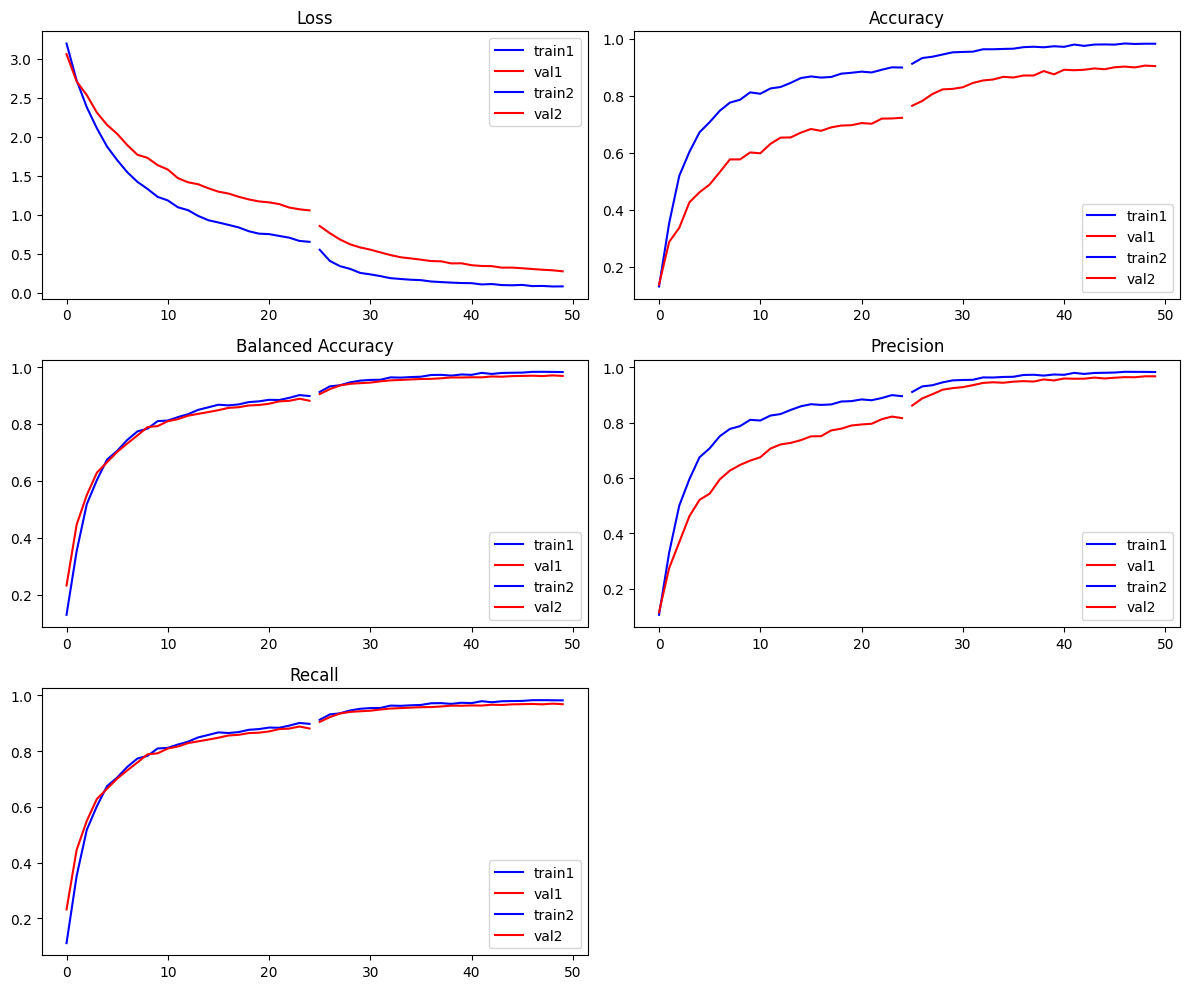

> TESTING <


100%|██████████| 274/274 [00:02<00:00, 99.60it/s] 
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Labels:      [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  9, 13, 14, 15, 17, 17, 17,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  

100%|██████████| 274/274 [00:02<00:00, 97.61it/s]


guessed  0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 13, 14, 15, 17, 17, 17, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 19, 24, 25, 26, 26, 26, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 6, 7]
[ 0  1  2  3  4  5  6  7  9 13 14 15 17 19 24 25 26]
lskdjfs [ 1  2  3  4  5  6  7  8  9 10 12 14 15 16 18 20 25 26 27 31 32]
[ 0  1  2  3  4  6  7  8  9 

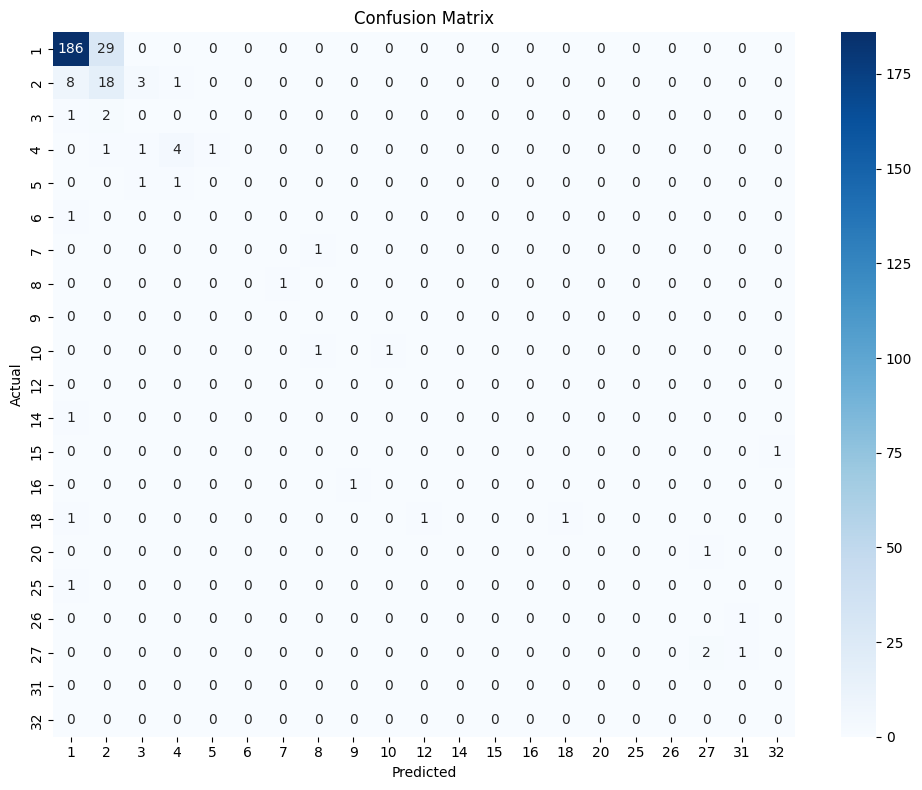

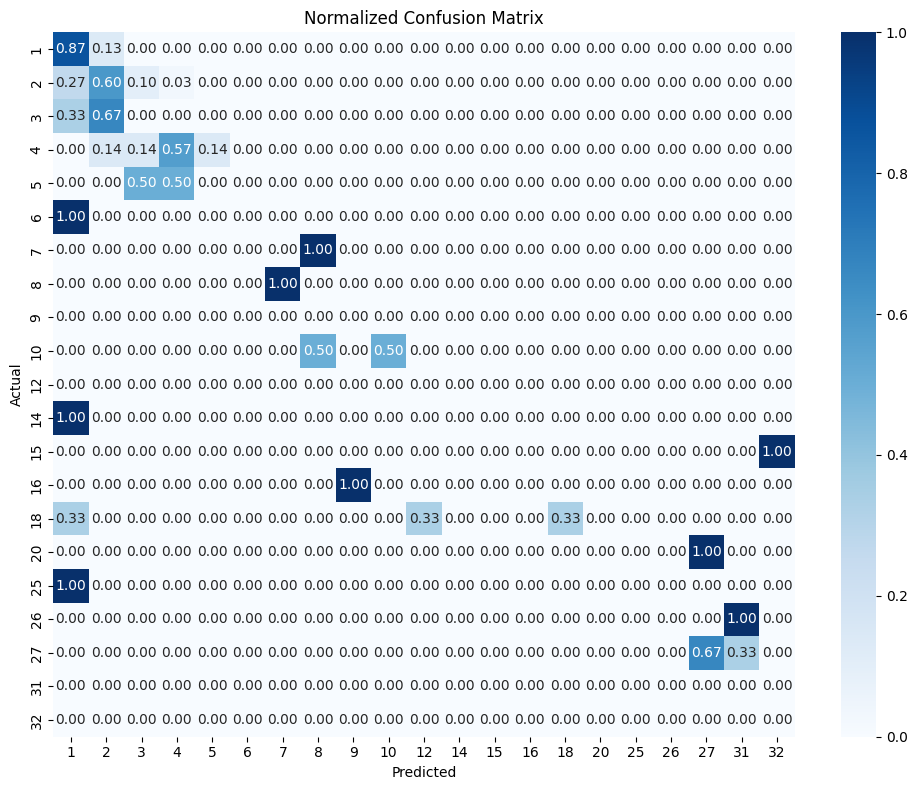

In [28]:
models_list = []

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Load a pre-trained convolutional neural network of your own choice from torchvision. Do not forget to change the last layer to match the number of classes = 32.
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 32)

models_list.append(["LEGO_resnet18", model])

# Define loss function for classification problem
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


# Create other model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 32)


models_list.append(["LEGO_resnet50", model])

# Define loss function for classification problem
loss_fn = nn.CrossEntropyLoss()

# use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# other models except resnet
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 32)

models_list.append(["LEGO_vgg16", model])




# Number of epochs
num_epochs = 50

# run all models
for model_name, model in models_list:
  print("======== ", model_name, " ========")

  # Step 1
  print("> STEP 1 <")
  # Freeze all layers except the last one
  for name, param in model.named_parameters():
      if "fc" not in name:
          param.requires_grad = False
  model.to(device)

  freeze_model_name = "freeze_" + model_name

  # Train the model
  train_history1, val_history1 = train(freeze_model_name, model, (num_epochs // 2), train_dataloader, validation_dataloader, loss_fn, optimizer)

  # Plot training evolution
  # plotTrainingHistory(train_history, val_history, freeze_model_name)


  # Step 2
  print("> STEP 2 <")
  # Unfreeze the pre-trained layers and train the whole model
  for name, param in model.named_parameters():
      if "fc" not in name:
          param.requires_grad = True
  model.to(device)

  # Train the model
  train_history2, val_history2 = train(model_name, model, num_epochs - (num_epochs // 2), train_dataloader, validation_dataloader, loss_fn, optimizer)

  # Plot training evolution
  plotTrainingHistory(train_history1, val_history1, train_history2, val_history2, model_name)



  # Test the model
  print("> TESTING <")
  # Load the best model
  checkpoint = torch.load('drive/MyDrive/VC/' + model_name + '_best_model.pth', map_location = device)

  # Evaluate model on test data
  model.load_state_dict(checkpoint['model'])

  test_loss, test_acc, test_precision, test_recall, test_balanced_acc = epoch_iter(model, test_dataloader, loss_fn, train=False)
  print(f"Test loss: {test_loss:.3f} | Test accuracy: {test_acc:.3f} | Test balanced accuracy: {test_balanced_acc:.3f} | Test precision: {test_precision:.3f} | Test recall: {test_recall:.3f}")

  print("========================")

  all_labels = []
  all_predictions = []

  for images, labels in tqdm(test_dataloader):
      images = images.to(device)
      labels = labels.to(device)

      with torch.no_grad():
          outputs = model(images)

      all_labels.extend(labels.cpu().numpy())
      all_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
  for i in range(len(all_labels)):
    if all_labels[i] == 24:
      print("guessed ", all_predictions[i])
  print(all_labels)
  print(np.unique(all_labels))
  pred_labels = np.unique(np.union1d(all_labels, all_predictions)) + 1
  print("lskdjfs", pred_labels)
  print(np.unique(all_predictions))

  cm = confusion_matrix(all_labels, all_predictions)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=pred_labels, yticklabels=pred_labels)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.savefig("drive/MyDrive/VC/" + model_name + "_confision_matrix.png")
  plt.show()

  cm = confusion_matrix(all_labels, all_predictions, normalize="true")
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=pred_labels, yticklabels=pred_labels)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Normalized Confusion Matrix")
  plt.tight_layout()
  plt.savefig("drive/MyDrive/VC/" + model_name + "_normalized_confision_matrix.png")
  plt.show()

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!